In [1]:
from IndexExtractor.Extract_NumbersInFileName import extract_numbers_from_folder
import pandas as pd
import json
from IPython.display import display
import cv2
import numpy as np
from typing import Dict, Union, List, Tuple, Optional
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import time
# 合計時間をためる変数
total_time = 0.0

Error: occlusion_scenes/lidar/images is not a valid directory.
[]


In [2]:
# IoU を計算する関数（既存のものを利用）
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    if boxAArea + boxBArea - interArea == 0:
        return 0.0
    return interArea / float(boxAArea + boxBArea - interArea)

In [3]:
# 3) ハンガリアン法を使った全体最適化版
from scipy.optimize import linear_sum_assignment

# 3) ハンガリアン法を使った全体最適化版
def associate_voxels_to_tracks_hungarian(
    merged_labels_path: str,
    results_path: str,
    round_decimals: int = 0,
    iou_thresh: float = 0.5
) -> pd.DataFrame:
    """
    フレームごとに全ての IoU を計算し、
    ハンガリアン法で最適マッチング（一対一、IoU>=閾値）
    を返します。
    """
    ml = pd.read_csv(merged_labels_path)
    rs = pd.read_csv(results_path)

    # 両方ともピクセル整数化
    for df in (ml, rs):
        df['x1_pix'] = df['x1'].round(round_decimals).astype(int)
        df['y1_pix'] = df['y1'].round(round_decimals).astype(int)
        df['w_pix']  = df['w'].round(round_decimals).astype(int)
        df['h_pix']  = df['h'].round(round_decimals).astype(int)

    frames = sorted(set(ml['frame']).intersection(rs['frame']))
    results = []
    for f in frames:
        A = ml[ml['frame'] == f].reset_index(drop=True)
        B = rs[rs['frame'] == f].reset_index(drop=True)
        N, M = len(A), len(B)
        if N == 0 or M == 0:
            continue
        iou_mat = np.zeros((N, M))
        for i, rowA in A.iterrows():
            for j, rowB in B.iterrows():
                boxA = (rowA.x1_pix, rowA.y1_pix, rowA.w_pix, rowA.h_pix)
                boxB = (rowB.x1_pix, rowB.y1_pix, rowB.w_pix, rowB.h_pix)
                iou_mat[i, j] = compute_iou(boxA, boxB)
        cost = 1.0 - iou_mat
        row_idx, col_idx = linear_sum_assignment(cost)
        for i, j in zip(row_idx, col_idx):
            if iou_mat[i, j] >= iou_thresh:
                Arow = A.iloc[i]
                Brow = B.iloc[j]
                rec = Arow.to_dict()
                rec['track_id'] = int(Brow.track_id)
                rec['frame'] = f
                rec['iou'] = float(iou_mat[i, j])
                results.append(rec)
    return pd.DataFrame(results)


In [4]:
# Cell 4: get_session_event_voxels_fallback 定義（disappeared は start-1 で補完）
def get_session_event_voxels_fallback(merged_df: pd.DataFrame, sessions_path: str) -> pd.DataFrame:
    sessions = pd.read_csv(sessions_path)
    recs = []
    for _, r in sessions.iterrows():
        s,e = int(r.start_frame), int(r.end_frame)
        disp = json.loads(r.get('disappeared','[]'))
        occ  = [(tid,f) for tid,f in json.loads(r.occluders) if tid]
        gen  = json.loads(r.get('generated','[]'))
        for tid,_ in disp:
            recs.append({'frame':s-1,'session_start':s,'session_end':e,
                         'event_type':'start','category':'disappeared','track_id':int(tid)})
        for tid,_ in occ:
            recs.append({'frame':s,'session_start':s,'session_end':e,
                         'event_type':'start','category':'occluder','track_id':int(tid)})
        for tid,_ in gen:
            recs.append({'frame':e,'session_start':s,'session_end':e,
                         'event_type':'end','category':'generated','track_id':int(tid)})
        for tid,_ in occ:
            recs.append({'frame':e,'session_start':s,'session_end':e,
                         'event_type':'end','category':'occluder','track_id':int(tid)})
    evdf = pd.DataFrame(recs)
    voxcols = [c for c in merged_df.columns if c not in ['frame','track_id']]
    return evdf.merge(merged_df[['frame','track_id']+voxcols],
                      on=['frame','track_id'], how='left')


In [5]:
# Cell 7: 必要ライブラリのインポートと射影関数定義
def project_voxel_aabb_with_depth(
    df: pd.DataFrame,
    extrinsics_file: str,
    internal_params: dict,
    distortion_params: dict,
    measurement_key: str,
    camera_key: str
) -> pd.DataFrame:
    """
    AABBボクセルを8頂点に展開し、画像平面への射影座標(im_u0–im_u7, im_v0–im_v7)
    とカメラ座標系での深度(z_cam0–z_cam7)を追加して返します。
    """
    # 外部パラメータ読み込み
    with open(extrinsics_file, 'r') as f:
        extr = json.load(f)
    cam_ext = extr[measurement_key][camera_key]

    # 回転ベクトル作成
    R = np.array(cam_ext['rot_mat'], dtype=float)
    rvec, _ = cv2.Rodrigues(R)
    # 並進ベクトル
    tvec = np.array(cam_ext['trans_vec'], dtype=float).flatten()
    # カメラ内部行列 & 歪み係数
    K    = internal_params[camera_key]
    dist = distortion_params[camera_key]

    # 各行のAABBを8頂点に展開
    corners = []
    for _, row in df.iterrows():
        xmin, ymin, zmin = row['x_min_world'], row['y_min_world'], row['z_min_world']
        xmax, ymax, zmax = row['x_max_world'], row['y_max_world'], row['z_max_world']
        pts = np.array([
            [xmin, ymin, zmin],
            [xmax, ymin, zmin],
            [xmax, ymax, zmin],
            [xmin, ymax, zmin],
            [xmin, ymin, zmax],
            [xmax, ymin, zmax],
            [xmax, ymax, zmax],
            [xmin, ymax, zmax]
        ], dtype=float)
        corners.append(pts)

    # 一括射影
    pts3d = np.vstack(corners).reshape(-1, 1, 3)        # (N*8,1,3)
    proj2d, _ = cv2.projectPoints(pts3d, rvec, tvec, K, dist)
    proj2d = proj2d.reshape(-1, 2)                      # (N*8,2)
    # カメラ座標系深度計算
    pts_cam = (R @ pts3d.reshape(-1, 3).T + tvec.reshape(3,1)).T  # (N*8,3)

    # 結果をDataFrameに格納
    out = df.reset_index(drop=True).copy()
    for i in range(8):
        out[f'im_u{i}']   = proj2d[i::8, 0]
        out[f'im_v{i}']   = proj2d[i::8, 1]
        out[f'z_cam{i}']  = pts_cam[i::8, 2]

    return out

In [6]:
def build_z_buffer(
    proj_df: pd.DataFrame,
    img_width: int,
    img_height: int,
    sample_vertex: int = 0
) -> np.ndarray:
    """
    指定した頂点 sample_vertex の深度情報を使い、
    画素ごとの最小深度バッファを構築します。
    
    Args:
        proj_df: project_voxel_aabb_with_depth の出力 DataFrame
        img_width: 画像幅 (px)
        img_height: 画像高さ (px)
        sample_vertex: 使用する頂点インデックス (0–7)
    Returns:
        z_buffer: 形状 (img_height, img_width) の最小深度マップ
    """
    # 初期化
    z_buffer = np.full((img_height, img_width), np.inf, dtype=float)
    
    # 射影座標と深度を整数インデックス化
    u = np.round(proj_df[f'im_u{sample_vertex}']).astype(int)
    v = np.round(proj_df[f'im_v{sample_vertex}']).astype(int)
    z = proj_df[f'z_cam{sample_vertex}'].values

    # 有効範囲のみ
    valid = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height)
    u, v, z = u[valid], v[valid], z[valid]

    # 各画素の最小深度を選択
    for ui, vi, zi in zip(u, v, z):
        if zi < z_buffer[vi, ui]:
            z_buffer[vi, ui] = zi

    return z_buffer

In [7]:
def compute_visibility_map_flex(
    proj_df: pd.DataFrame,
    img_width: int,
    img_height: int,
    vertices: list[int] = list(range(8)),
    eps: float = 1e-2,
    min_visible_ratio: float = 0.5
) -> dict:
    """
    頂点ごとにZバッファを構築し、各ボクセル行の可視性を割合ベースで判定します。

    Args:
      proj_df: project_voxel_aabb_with_depth の出力
      img_width, img_height: 画像サイズ
      vertices: チェックする頂点インデックスリスト
      eps: 深度誤差許容
      min_visible_ratio: チェックした頂点のうち、この割合以上が可視ならOK
    Returns:
      vis_map: {row_index: bool}
    """
    # 1) 頂点ごとにZバッファを構築して辞書に格納
    z_buffers = {}
    for vtx in vertices:
        z_buffers[vtx] = build_z_buffer(
            proj_df, img_width, img_height, sample_vertex=vtx
        )

    # 2) 各行を判定
    vis_map = {}
    for idx, row in proj_df.iterrows():
        visible_count = 0
        for vtx in vertices:
            u = int(round(row[f'im_u{vtx}']))
            v = int(round(row[f'im_v{vtx}']))
            z = row[f'z_cam{vtx}']
            # 範囲外は不可視扱い
            if not (0 <= u < img_width and 0 <= v < img_height):
                continue
            zb = z_buffers[vtx][v, u]
            if z <= zb + eps:
                visible_count += 1

        # 判定
        ratio = visible_count / len(vertices)
        print(f"idx={idx}: visible_count={visible_count}, ratio={ratio:.2f}")
        vis_map[idx] = (ratio >= min_visible_ratio)

    return vis_map

In [8]:
# Cell 11a: 三店方式で画像を探すユーティリティ関数群
def parse_aux_filename(fname: str) -> Optional[Tuple[str, str, str]]:
    """
    新フォーマット: sensor_fileNum_frame
    例: "sensorA_000123_0456.jpg" -> ("sensorA", "000123", "0456")
    """
    base = os.path.splitext(os.path.basename(fname))[0]
    parts = base.split('_')
    if len(parts) != 3:
        return None
    sensor, file_num, frame_str = parts
    return sensor, file_num, frame_str

def find_aux_file(
    frame: int,
    aux_folder: str,
    aux_ext: str = ".jpg",
    aux_frame_fmt: str = "{:04d}"
) -> Optional[str]:
    target = aux_frame_fmt.format(frame)
    for fname in os.listdir(aux_folder):
        if not fname.endswith(aux_ext):
            continue
        parsed = parse_aux_filename(fname)
        if parsed and parsed[2] == target:
            return os.path.join(aux_folder, fname)
    return None

def find_main_file(
    aux_fname: str,
    main_folder: str,
    main_ext: str = ".jpg"
) -> Optional[str]:
    parsed = parse_aux_filename(os.path.basename(aux_fname))
    if not parsed:
        return None
    _, file_num, _ = parsed
    for fname in os.listdir(main_folder):
        if not fname.endswith(main_ext):
            continue
        if file_num in fname:
            return os.path.join(main_folder, fname)
    return None

def find_three_stage_image(
    frame: int,
    aux_folder: str,
    main_folder: str,
    aux_ext: str = ".jpg",
    main_ext: str = ".jpg",
    aux_frame_fmt: str = "{:04d}"
) -> Optional[str]:
    aux_path = find_aux_file(frame, aux_folder, aux_ext, aux_frame_fmt)
    if aux_path is None:
        print(f"⚠️ 補助フォルダに frame={frame} のファイルが見つかりません")
        return None
    main_path = find_main_file(aux_path, main_folder, main_ext)
    if main_path is None:
        sensor, file_num, _ = parse_aux_filename(aux_path)
        print(f"⚠️ 本命フォルダに file_num='{file_num}' のファイルが見つかりません")
    return main_path

In [9]:
def get_frame_detections(
    frame: int,
    aux_folder: str,
    main_folder: str,
    aux_ext: str,
    main_ext: str,
    aux_frame_fmt: str,
) -> tuple[str, np.ndarray, list[list[float]]] | None:
    """
    frame ごとに一度だけ以下を実行してキャッシュする
      1) find_three_stage_image → img_path
      2) cv2.imread → img_rgb
      3) YOLO 推論 → yolo_boxes (xywh 左上起点)
    返回 (img_path, img_rgb, yolo_boxes) or None
    """

    img_path = find_three_stage_image(
        frame, aux_folder, main_folder, aux_ext, main_ext, aux_frame_fmt
    )
    if img_path is None:
        return None

    img = cv2.imread(img_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # YOLO 検出
    results = yolo_model.predict(img_rgb, verbose=False)
    yolo_boxes = []
    for result in results:
        for box in result.boxes.xywh.cpu().numpy():  # (cx, cy, w, h)
            x, y, w, h = box
            yolo_boxes.append([x - w/2, y - h/2, w, h])

    return img_path, img_rgb, yolo_boxes

In [10]:
# Cell 11: 三店方式対応 overlay_single_frame with ID labels
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

EDGES = [
    (0,1),(1,2),(2,3),(3,0),
    (4,5),(5,6),(6,7),(7,4),
    (0,4),(1,5),(2,6),(3,7)
]

# YOLOモデルはグローバルで一度だけ読み込む
yolo_model = YOLO("aoki_project/assets/models/yolo11m.pt")

def overlay_single_frame(
    proj_df: pd.DataFrame,
    frame: int,
    aux_folder: str,
    main_folder: str,
    aux_ext: str = ".jpg",
    main_ext: str = ".jpg",
    aux_frame_fmt: str = "{:06d}",
    match_iou_thresh: float = 0.5,
    other_iou_thresh: float = None,  # Noneなら自動で match_iou_thresh/2 に
) -> tuple[bool, list[float], str] | None:
    """
    • 指定フレームで YOLO 検出 → IoU マッチング（strict + loose）
    • 可視化は必ず行う
    • マッチ時は (True, [x,y,w,h], img_path) を返し、
      マッチしなければ (False, [], img_path) を返して終了。
    """
    if other_iou_thresh is None:
        other_iou_thresh = match_iou_thresh / 2.0

    print(f"strict_match:{strict_match}")
    
    det = get_frame_detections(
        frame, aux_folder, main_folder,
        aux_ext, main_ext, aux_frame_fmt
    )
    if det is None:
        print(f"[DEBUG] frame={frame}: 画像/検出取得失敗")
        return None
    img_path, img_rgb, yolo_boxes = det
    print(f"[DEBUG] frame={frame}: {len(yolo_boxes)} boxes, strict>{match_iou_thresh}, loose>{other_iou_thresh}")

    # proj_df は 1行だけ想定
    row = proj_df.iloc[0]
    pts = np.stack([[row[f"im_u{i}"], row[f"im_v{i}"]] for i in range(8)])
    x_min,y_min = pts.min(axis=0); x_max,y_max = pts.max(axis=0)
    voxel_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    print(f"[DEBUG] voxel_bbox={voxel_bbox}")

    # 全検出との IoU 計算
    iou_list = [(bbox, compute_iou(voxel_bbox, bbox)) for bbox in yolo_boxes]
    for bbox,iou in iou_list:
        print(f"  [DEBUG] det={bbox}, IoU={iou:.4f}")

    # 1) 厳しい閾値を超えるもの
    strict = [(b,i) for b,i in iou_list if i > match_iou_thresh]
    # 2) 緩い閾値を超えるもの（strict は除外）
    loose = [(b,i) for b,i in iou_list
             if i > other_iou_thresh and i <= match_iou_thresh]

    print(f"  [DEBUG] strict={len(strict)}, loose={len(loose)}")
    matched = False
    matched_bbox = None
    if strict_match:
        if len(strict) == 1 and len(loose) == 0:
            matched = True
            matched_bbox, best_iou = strict[0]
            print(f"[DEBUG] → MATCHED frame={frame}, bbox={matched_bbox}, IoU={best_iou:.4f}")
        else:
            print(f"[DEBUG] → NO MATCH frame={frame}")
    else:
        if len(strict) == 1:
            matched = True
            matched_bbox, best_iou = strict[0]
            print(f"[DEBUG] → MATCHED frame={frame}, bbox={matched_bbox}, IoU={best_iou:.4f}")
        else:
            print(f"[DEBUG] → NO MATCH frame={frame}")

    # 可視化用クロップ領域
    disp_x, disp_y, disp_w, disp_h = (matched_bbox or voxel_bbox)
    x1 = int(max(0, disp_x)); y1 = int(max(0, disp_y))
    x2 = int(min(img_rgb.shape[1], disp_x + disp_w))
    y2 = int(min(img_rgb.shape[0], disp_y + disp_h))

    crop = img_rgb[y1:y2, x1:x2].copy()
    shifted_pts = pts - np.array([x1, y1])

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(crop)

    # 1) ワイヤーフレーム
    color = 'lime' if matched_bbox else 'red'
    for i0, i1 in EDGES:
        p0, p1 = shifted_pts[i0], shifted_pts[i1]
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], linewidth=1.5, color=color)

    # 2) 元の検出BBox のオーバーレイ
    for det_bbox in yolo_boxes:
        bx, by, bw, bh = det_bbox
        # クロップ内に含まれるかチェック
        if (bx + bw > x1 and bx < x2 and by + bh > y1 and by < y2):
            # クロップ座標系に変換
            rx = bx - x1
            ry = by - y1
            # 緑は strict マッチ、青は loose マッチ、白はそれ以外…など好みで
            iou = compute_iou(voxel_bbox, det_bbox)
            if iou > match_iou_thresh:
                edge_color = 'yellow'
            elif iou > other_iou_thresh:
                edge_color = 'cyan'
            else:
                edge_color = 'white'
            rect = patches.Rectangle(
                (rx, ry), bw, bh,
                linewidth=2, edgecolor=edge_color, facecolor='none'
            )
            ax.add_patch(rect)

    # 3) ID ラベル
    u_cent, v_cent = shifted_pts[:,0].mean(), shifted_pts[:,1].mean()
    ax.text(
        u_cent, v_cent,
        f"ID:{int(row['track_id'])}",
        color='yellow', fontsize=12, fontweight='bold',
        ha='center', va='center',
        bbox=dict(facecolor='black', alpha=0.5, pad=2)
    )

    ax.set_axis_off()
    ax.set_title(f"Frame {frame} | Matched:{bool(matched_bbox)}")
    plt.show()

    # 戻り値
    return (matched, matched_bbox or [], img_path)

In [11]:
def overlay_single_frame_simple(
    proj_df: pd.DataFrame,
    frame: int,
    aux_folder: str,
    main_folder: str,
    aux_ext: str = ".jpg",
    main_ext: str = ".jpg",
    aux_frame_fmt: str = "{:06d}",
    match_iou_thresh: float = 0.5,
    other_iou_thresh: float = None,
) -> tuple[bool, list[float], str] | None:
    """
    • proj_df から voxel_bbox を計算
    • get_frame_detections で画像パス＋検出ボックス取得
    • strict/loose IoU マッチング
    • (matched, matched_bbox or [], img_path) を返す
    """
    if other_iou_thresh is None:
        other_iou_thresh = match_iou_thresh / 2.0

    # 画像取得＋YOLO検出
    det = get_frame_detections(
        frame, aux_folder, main_folder,
        aux_ext, main_ext, aux_frame_fmt
    )
    if det is None:
        return None
    img_path, img_rgb, yolo_boxes = det

    # proj_df は１行想定
    row = proj_df.iloc[0]
    pts = np.stack([[row[f"im_u{i}"], row[f"im_v{i}"]] for i in range(8)])
    x_min, y_min = pts.min(axis=0)
    x_max, y_max = pts.max(axis=0)
    voxel_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

    # 全検出との IoU 計算
    iou_list = [(bbox, compute_iou(voxel_bbox, bbox)) for bbox in yolo_boxes]
    strict = [(b, i) for b, i in iou_list if i > match_iou_thresh]
    loose  = [(b, i) for b, i in iou_list if other_iou_thresh < i <= match_iou_thresh]

    # マッチ判定（strict_match は外部で定義されている想定）
    matched = False
    matched_bbox = []
    if strict_match:
        if len(strict) == 1 and not loose:
            matched = True
            matched_bbox, _ = strict[0]
    else:
        if len(strict) == 1:
            matched = True
            matched_bbox, _ = strict[0]

    return (matched, matched_bbox or [], img_path)

In [12]:
# Cell 12: trace_and_overlay_for_events を可視性対応版に書き換え
def trace_and_overlay_for_events(
    events_df: pd.DataFrame,
    merged_df: pd.DataFrame,
    direction: int,
    extrinsics_file: str,
    internal_params: dict,
    distortion_params: dict,
    measurement_key: str,
    camera_key: str,
    aux_folder: str,
    main_folder: str,
    vis_map: dict,
    aux_ext: str = ".jpg",
    main_ext: str = ".jpg",
    aux_frame_fmt: str = "{:04d}",
    max_steps: int = 20,
    skip_frames: int = 10
):

    for ev_idx, ev in events_df.iterrows():
        frame = int(ev['frame'])
        tid   = int(ev['track_id'])

        for i in range(max_steps):

            if i < skip_frames:
                frame += direction
                continue

            subset = merged_df[(merged_df.track_id==tid)&(merged_df.frame==frame)]
            if subset.empty:
                frame += direction
                print(f"{frame}にデータがありません")
                continue

            # 射影＋深度付き DataFrame
            proj = project_voxel_aabb_with_depth(
                subset,
                extrinsics_file,
                internal_params,
                distortion_params,
                measurement_key,
                camera_key
            )

            # 可視性チェック
            # idx = proj.index[0]
            # if not vis_map.get(idx, False):
            #     frame += direction
            #     continue

            # 三店方式でオーバーレイ
            result = overlay_single_frame(
                proj,
                frame,
                aux_folder,
                main_folder,
                aux_ext,
                main_ext,
                aux_frame_fmt,
                match_iou_thresh = 0.35,
            )
                    
            if result is None:
                # 画像自体が取得できない場合など
                print(f"マッチングができずスキップされたフレーム：{frame}")
                frame += direction
                continue

            matched, bbox_xywh, img_path = result

            if matched:
                # マッチ成功 → events_df に書き込み＆break
                x,y,w,h = bbox_xywh
                events_df.at[ev_idx, "matched_frame"]      = frame
                events_df.at[ev_idx, "matched_image_path"] = img_path
                events_df.at[ev_idx, "matched_x"]          = x
                events_df.at[ev_idx, "matched_y"]          = y
                events_df.at[ev_idx, "matched_w"]          = w
                events_df.at[ev_idx, "matched_h"]          = h
                
                return events_df
                print("match_success")
                break

            # マッチしなかったら次フレームへ
            frame += direction

In [13]:
# Cell 21: カメラ視点評価関数定義
def evaluate_camera_view(
    events_df: pd.DataFrame,
    merged_df: pd.DataFrame,
    extr_file: str,
    measurement_key: str,
    camera_key: str,
    internal_params: Dict[str,np.ndarray],
    distortion_params: Dict[str,np.ndarray],
    img_width: int,
    img_height: int,
    vertices: List[int] = list(range(8)),
    eps: float = 1e-2
) -> pd.DataFrame:
    """
    各イベントボクセル（track_id, frame）について、
    このカメラ視点での
      - visible_count: 可視だった頂点数 (0–len(vertices))
      - distance: カメラ位置 ⇔ ボクセル中心距離
    を計算し、行単位で返します。
    """
    # 1) イベント分だけ project + depth 付き DataFrame
    proj = project_voxel_aabb_with_depth(
        events_df, extr_file, internal_params,
        distortion_params, measurement_key, camera_key
    )
    # 2) カメラ位置計算
    ext = json.load(open(extr_file))[measurement_key][camera_key]
    R = np.array(ext['rot_mat'], float)
    T = np.array(ext['trans_vec'], float).flatten()
    cam_pos = -(R.T @ T)
    # 3) 頂点ごとの Z-buffer 構築
    zbufs = {v: build_z_buffer(proj, img_width, img_height, v) for v in vertices}
    # 4) イベントごとに評価
    records = []
    for idx, row in proj.iterrows():
        # ボクセル中心
        center = np.array([
            (row.x_min_world + row.x_max_world)/2,
            (row.y_min_world + row.y_max_world)/2,
            (row.z_min_world + row.z_max_world)/2
        ])
        dist = np.linalg.norm(center - cam_pos)
        # 可視頂点数
        vis = 0
        for v in vertices:
            u = int(round(row[f'im_u{v}'])); vv = int(round(row[f'im_v{v}']))
            z = row[f'z_cam{v}']
            if 0 <= u < img_width and 0 <= vv < img_height:
                if z <= zbufs[v][vv, u] + eps:
                    vis += 1
        records.append({
            'idx':    idx,
            'track_id': int(row.track_id),
            'frame':  int(row.frame),
            'visible_count': vis,
            'distance':      dist
        })
    return pd.DataFrame(records)


In [ ]:
near_1_3_dict = {'00754-01276': [915, 1086], 
                '01943-02233': [1307, 1402], 
                '02987-03451': [1647, 1799], 
                '04060-04466': [2002, 2135], 
                '08323-08787': [3398, 3551], 
                '14094-14413': [5290, 5395], 
                '16298-16588': [6019, 6114], 
                '18473-18763': [6780, 6828], 
                '24708-25143': [8778, 8921], 
                '27405-27650': [9665, 9745]}

filename = '00754-01276'
skip_param_start = 5
skip_param_end = 5
strict_match = True
max_steps_start = 20
max_steps_end = 20

detection_csv = f'system_output/datasets_up_to_lidar_tracking/tracking_and_processed_detection/near_1-3_iou_0.3/detection/{filename}.csv'
tracking_csv = f'system_output/datasets_up_to_lidar_tracking/tracking_and_processed_detection/near_1-3_iou_0.3/tracking/{filename}.csv'
occlusion_session_csv = f"system_output/datasets_up_to_lidar_tracking/tracking_and_processed_detection/near_1-3_iou_0.3/occlusion_extract_old_alghorithm/{filename}.csv"
output_dir = f"system_output/camfusion_postprocess/0710_skip5/camfusion_csv/{filename}.csv"


aux_folder=f"aoki_project/data/read_only/frames_img/near-end/lidar/day1_measurement3_scene_camera_frame_{filename}"


main_folder=[
    f"aoki_project/data/read_only/frames_img/near-end/camera1/day1_measurement3_scene_camera_frame_{filename}",
    f"aoki_project/data/read_only/frames_img/near-end/camera2/day1_measurement3_scene_camera_frame_{filename}",
    f"aoki_project/data/read_only/frames_img/near-end/camera3/day1_measurement3_scene_camera_frame_{filename}"
]


# カメラリストと設定
cams = ['camera1','camera2','camera3']


cam_settings = {
    'camera1': {'aux_folder': aux_folder,'main_folder':main_folder[0],'img_w':1920,'img_h':1080},
    'camera2': {'aux_folder': aux_folder,'main_folder':main_folder[1],'img_w':1920,'img_h':1080},
    'camera3': {'aux_folder': aux_folder,'main_folder':main_folder[2],'img_w':1920,'img_h':1080},
}

# Cell 8: カメラパラメータ定義
extr_file = './aoki_project/data/read_only/cam_extrinsics_20241127.json'
measurement_key = 'day1_measurement3'
camera_key = 'camera1'

In [15]:
#計測対象１
t0 = time.perf_counter()

# Cell 3: IoUマッチング実行
merged_df_iou = associate_voxels_to_tracks_hungarian(
    detection_csv,
    tracking_csv,
    iou_thresh=0.1
)
# print("merged_df_iou rows:", len(merged_df_iou))
# merged_df_iou.head()

# Cell 5: セッションイベント取得
session_events_fb = get_session_event_voxels_fallback(
    merged_df_iou,
    occlusion_session_csv,
)

# NANを含む行は使い道がないので削除する（ボクセル取得に失敗している）
session_events_fb = session_events_fb.dropna()
#print("session_events_fb rows:", len(session_events_fb))

session_events_fb = session_events_fb.drop_duplicates(
    subset=['session_start', 'session_end', 'event_type', 'track_id'],
    keep='first'   # 最初の行だけ残して重複行を削除
).reset_index(drop=True)

# カメラの内部パラメータ
internal_params = {
    "camera1": np.array([[1652.28388, 0, 1935.70302], [0, 1640.08172, 1075.17311], [0, 0, 1]]),
    "camera2": np.array([[1637.22099, 0, 1936.53930], [0, 1626.06543, 1085.46740], [0, 0, 1]]),
    "camera3": np.array([[1626.07893, 0, 1940.31291], [0, 1615.78810, 1088.17493], [0, 0, 1]])
}

# カメラの歪み係数
distortion_params = {
    "camera1": np.array([-0.05140987, 0.01748709, -0.00054638, 0.00246013, -0.00634029]),
    "camera2": np.array([-0.04723424, 0.01433632, 0.00083376, 0.00295799, -0.00621069]),
    "camera3": np.array([-0.04368585, 0.00606696, 0.0004664, 0.00202686, -0.00143657])
}

# 1) 全 voxel の射影＋深度
proj_all = project_voxel_aabb_with_depth(
    merged_df_iou,
    extr_file,
    internal_params,
    distortion_params,
    measurement_key,
    camera_key
)

# 2) Z-バッファ＋可視性マップ生成
vis_map = compute_visibility_map_flex(
    proj_all,
    img_width=1920,
    img_height=1080,
    vertices=list(range(8)),
    eps=1e-3,
    min_visible_ratio=0.1
)

# 3) イベント df（例：start_events）のインデックスを取得
event_idx = session_events_fb.index

# 4) proj_all からイベント行だけをフィルタ
proj_events = proj_all.loc[proj_all.index.isin(event_idx)].copy()

# 5) 可視性列を追加
proj_events['visible'] = proj_events.index.map(lambda i: vis_map.get(i, False))

# Cell 22: 各カメラ評価の実行

evals = {}
for cam in cams:
    cfg = cam_settings[cam]
    df_cam = evaluate_camera_view(
        events_df=session_events_fb,
        merged_df=merged_df_iou,
        extr_file=extr_file,
        measurement_key=measurement_key,
        camera_key=cam,
        internal_params=internal_params,
        distortion_params=distortion_params,
        img_width=cfg['img_w'],
        img_height=cfg['img_h']
    )
    evals[cam] = df_cam
    print(f"{cam}: avg visible={df_cam.visible_count.mean():.1f}, avg dist={df_cam.distance.mean():.1f}")


# Cell 23: 最適視点の選定（遮蔽度閾値フィルタ → 距離最小で決定）

# 遮蔽度閾値（可視頂点数の最小値）
min_visible_count = 4

best_cams = []
for i in range(len(session_events_fb)):
    # イベントごとに、各カメラの (cam, visible_count, distance) を収集
    candidates = []
    for cam in cams:
        df_cam = evals[cam]
        row = df_cam.iloc[i]
        candidates.append({
            'camera': cam,
            'visible_count': int(row.visible_count),
            'distance':      float(row.distance)
        })

    # 1) 遮蔽度閾値クリアのものだけ抽出
    survivors = [c for c in candidates if c['visible_count'] >= min_visible_count]
    if len(survivors) == 0:
        # 閾値クリアなし → 全体から選ぶ（fallback）
        pool = candidates
    else:
        # 閾値クリアしたものだけで次の選定
        pool = survivors

    # 2) 距離最小のカメラを選ぶ
    best = min(pool, key=lambda c: c['distance'])
    best_cams.append(best['camera'])

    # （デバッグ出力）
    #print(f"Event {i}: pool={[ (c['camera'],c['visible_count'],round(c['distance'],1)) for c in pool ]} → best = {best['camera']}")

# session_events に結果を追加
session_events_fb['best_camera'] = best_cams
#session_events_fb.head(15)

# Cell 9: start_events/end_eventsを抽出し、各々射影して確認
start_events = session_events_fb[session_events_fb['event_type']=='start']
end_events   = session_events_fb[session_events_fb['event_type']=='end']

# 各セルの末尾
t1 = time.perf_counter()
elapsed = t1 - t0

# グローバル変数に足し込む
total_time += elapsed

print(f"このセル: {elapsed:.3f} 秒, 合計: {total_time:.3f} 秒")

idx=0: visible_count=7, ratio=0.88
idx=1: visible_count=8, ratio=1.00
idx=2: visible_count=8, ratio=1.00
idx=3: visible_count=8, ratio=1.00
idx=4: visible_count=8, ratio=1.00
idx=5: visible_count=8, ratio=1.00
idx=6: visible_count=0, ratio=0.00
idx=7: visible_count=4, ratio=0.50
idx=8: visible_count=0, ratio=0.00
idx=9: visible_count=8, ratio=1.00
idx=10: visible_count=8, ratio=1.00
idx=11: visible_count=2, ratio=0.25
idx=12: visible_count=8, ratio=1.00
idx=13: visible_count=8, ratio=1.00
idx=14: visible_count=8, ratio=1.00
idx=15: visible_count=7, ratio=0.88
idx=16: visible_count=4, ratio=0.50
idx=17: visible_count=2, ratio=0.25
idx=18: visible_count=0, ratio=0.00
idx=19: visible_count=0, ratio=0.00
idx=20: visible_count=8, ratio=1.00
idx=21: visible_count=8, ratio=1.00
idx=22: visible_count=8, ratio=1.00
idx=23: visible_count=8, ratio=1.00
idx=24: visible_count=8, ratio=1.00
idx=25: visible_count=8, ratio=1.00
idx=26: visible_count=8, ratio=1.00
idx=27: visible_count=8, ratio=1.00
id

912にデータがありません
911にデータがありません
910にデータがありません
909にデータがありません
908にデータがありません
907にデータがありません
906にデータがありません
905にデータがありません
904にデータがありません
903にデータがありません
902にデータがありません
901にデータがありません
900にデータがありません
899にデータがありません
898にデータがありません
912にデータがありません
911にデータがありません
910にデータがありません
909にデータがありません
908にデータがありません
907にデータがありません
906にデータがありません
905にデータがありません
904にデータがありません
903にデータがありません
902にデータがありません
901にデータがありません
900にデータがありません
899にデータがありません
898にデータがありません
strict_match:True
[DEBUG] frame=921: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[187.20608775715687, 990.0186190167259, 303.25768608876456, 170.24690746448152]
  [DEBUG] det=[1376.41748046875, 1051.0382080078125, 130.78174, 288.8833], IoU=0.0000
  [DEBUG] det=[586.6119384765625, 1819.708740234375, 208.02417, 209.66162], IoU=0.0000
  [DEBUG] det=[2679.203369140625, 1303.6328125, 114.34717, 294.90918], IoU=0.0000
  [DEBUG] det=[514.38037109375, 918.7869873046875, 97.13745, 214.56079], IoU=0.0000
  [DEBUG] det=[1387.1025390625, 871.744140625, 75.66724, 171.43823], I

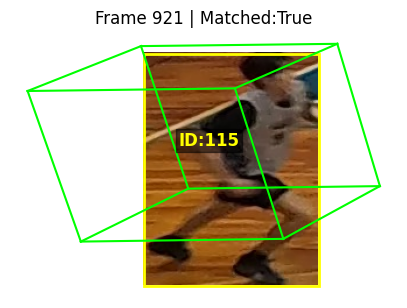

strict_match:True
[DEBUG] frame=922: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[368.79150642973514, 909.3434487538682, 318.5031646807447, 201.58823845530196]
  [DEBUG] det=[1611.740966796875, 818.5147705078125, 67.47485, 185.26245], IoU=0.0000
  [DEBUG] det=[2679.453369140625, 1299.0179443359375, 113.92969, 299.6543], IoU=0.0000
  [DEBUG] det=[586.795654296875, 1819.79736328125, 208.35498, 209.844], IoU=0.0000
  [DEBUG] det=[350.3519744873047, 996.1171875, 126.84891, 206.90552], IoU=0.1596
  [DEBUG] det=[1380.301513671875, 855.908935546875, 72.30176, 185.55786], IoU=0.0000
  [DEBUG] det=[533.0869140625, 914.0345153808594, 93.40161, 217.1629], IoU=0.2782
  [DEBUG] det=[1270.593994140625, 755.5264892578125, 91.68408, 187.56592], IoU=0.0000
  [DEBUG] det=[1362.9823608398438, 1057.4081420898438, 120.44495, 288.3922], IoU=0.0000
  [DEBUG] det=[3568.58935546875, 1375.287841796875, 145.94678, 185.18726], IoU=0.0000
  [DEBUG] det=[1517.147705078125, 772.354248046875, 66.267334, 173

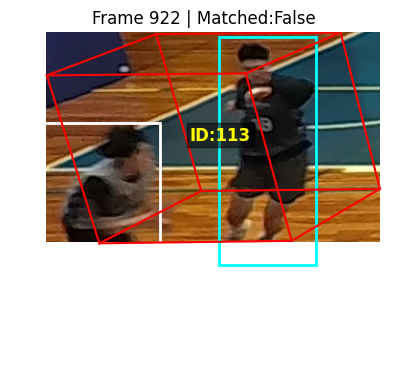

strict_match:True
[DEBUG] frame=921: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[355.60784193789095, 915.2155952721461, 308.28108068809934, 195.47017239853938]
  [DEBUG] det=[1376.41748046875, 1051.0382080078125, 130.78174, 288.8833], IoU=0.0000
  [DEBUG] det=[586.6119384765625, 1819.708740234375, 208.02417, 209.66162], IoU=0.0000
  [DEBUG] det=[2679.203369140625, 1303.6328125, 114.34717, 294.90918], IoU=0.0000
  [DEBUG] det=[514.38037109375, 918.7869873046875, 97.13745, 214.56079], IoU=0.2984
  [DEBUG] det=[1387.1025390625, 871.744140625, 75.66724, 171.43823], IoU=0.0000
  [DEBUG] det=[2660.3004150390625, 804.280029296875, 75.31421, 168.25732], IoU=0.0000
  [DEBUG] det=[1609.955810546875, 832.5943603515625, 76.18286, 193.88013], IoU=0.0000
  [DEBUG] det=[3570.8115234375, 1377.1946411132812, 144.30908, 182.995], IoU=0.0000
  [DEBUG] det=[287.567138671875, 998.4767456054688, 150.25543, 199.93762], IoU=0.1138
  [DEBUG] det=[1280.0634765625, 754.5880126953125, 100.03247, 190.82

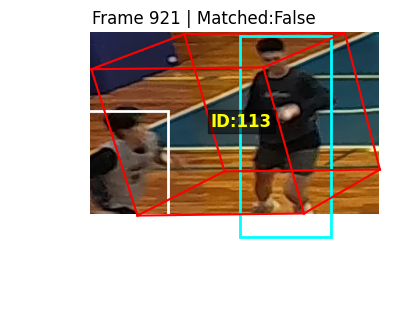

strict_match:True
[DEBUG] frame=920: 28 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[356.2379957229941, 918.9599982243384, 276.9802076856529, 184.71149672420563]
  [DEBUG] det=[1387.23583984375, 1049.175048828125, 129.98901, 291.84546], IoU=0.0000
  [DEBUG] det=[275.6963348388672, 989.8141784667969, 150.59842, 210.04791], IoU=0.1066
  [DEBUG] det=[499.2051696777344, 926.6121826171875, 106.26398, 212.79492], IoU=0.3423
  [DEBUG] det=[586.896484375, 1819.456787109375, 208.22595, 209.87695], IoU=0.0000
  [DEBUG] det=[2679.658203125, 1305.38720703125, 113.63379, 294.22632], IoU=0.0000
  [DEBUG] det=[2679.197021484375, 807.1279907226562, 65.47705, 167.08044], IoU=0.0000
  [DEBUG] det=[1289.000732421875, 755.0806274414062, 104.01416, 190.29895], IoU=0.0000
  [DEBUG] det=[1389.444091796875, 876.9110107421875, 74.4707, 184.63403], IoU=0.0000
  [DEBUG] det=[1042.984619140625, 811.2336120605469, 103.120605, 231.72125], IoU=0.0000
  [DEBUG] det=[3567.988037109375, 1376.91748046875, 146.317

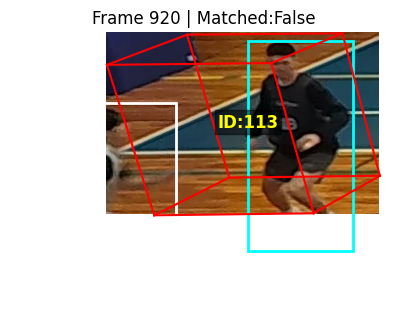

strict_match:True
[DEBUG] frame=919: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[373.24630669322505, 898.8894844641131, 244.42738857433778, 205.41633192164568]
  [DEBUG] det=[265.81451416015625, 983.2391357421875, 143.73718, 217.66089], IoU=0.0570
  [DEBUG] det=[1394.65771484375, 1053.47119140625, 124.68091, 290.21704], IoU=0.0000
  [DEBUG] det=[2680.8916015625, 1306.598388671875, 112.80176, 298.49756], IoU=0.0000
  [DEBUG] det=[505.93040466308594, 915.3652648925781, 102.51346, 231.65912], IoU=0.3548
  [DEBUG] det=[1380.7262573242188, 886.3617248535156, 89.31995, 185.56879], IoU=0.0000
  [DEBUG] det=[586.7133483886719, 1820.3258056640625, 207.45172, 209.39282], IoU=0.0000
  [DEBUG] det=[1068.4896240234375, 827.90771484375, 101.4668, 211.62854], IoU=0.0000
  [DEBUG] det=[3569.492431640625, 1375.0623168945312, 144.66943, 183.74744], IoU=0.0000
  [DEBUG] det=[385.57171630859375, 1821.95703125, 181.1427, 182.04102], IoU=0.0000
  [DEBUG] det=[1208.60009765625, 859.5862121582031, 

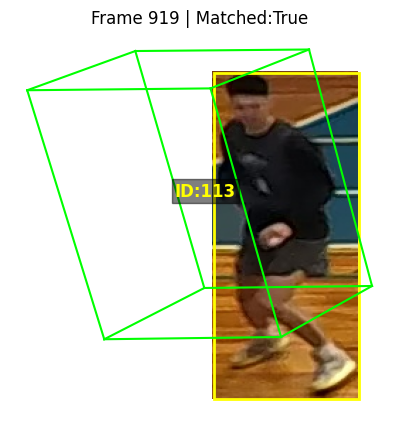

strict_match:True
[DEBUG] frame=941: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1329.9024464053218, 853.9892597675934, 132.3687553507457, 161.1366092853741]
  [DEBUG] det=[1120.8882446289062, 1060.91162109375, 124.4491, 289.49146], IoU=0.0000
  [DEBUG] det=[624.50146484375, 845.8082580566406, 84.50171, 234.69525], IoU=0.0000
  [DEBUG] det=[587.06640625, 1819.9493408203125, 210.02808, 208.93066], IoU=0.0000
  [DEBUG] det=[1173.2060546875, 870.2048645019531, 138.99683, 199.89398], IoU=0.0000
  [DEBUG] det=[3566.3707275390625, 1376.1118774414062, 148.88745, 184.01257], IoU=0.0000
  [DEBUG] det=[3411.642578125, 1392.3080444335938, 173.42676, 177.30579], IoU=0.0000
  [DEBUG] det=[384.1332244873047, 1822.0371704101562, 181.84158, 179.76746], IoU=0.0000
  [DEBUG] det=[1079.8232421875, 780.4287109375, 110.07056, 200.54224], IoU=0.0000
  [DEBUG] det=[1366.8126831054688, 851.4632568359375, 112.215454, 221.65063], IoU=0.4991
  [DEBUG] det=[2685.0947265625, 1301.2583618164062, 149.6967

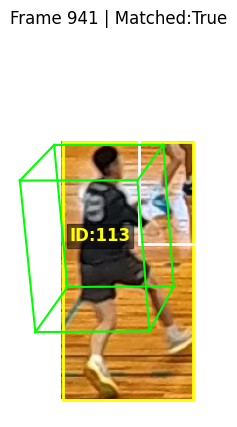

strict_match:True
[DEBUG] frame=955: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[618.8102355259275, 766.8101550641522, 170.37327064351894, 109.03115999169017]
  [DEBUG] det=[977.5395202636719, 1042.9990234375, 113.565, 288.39917], IoU=0.0000
  [DEBUG] det=[586.6802978515625, 1820.02880859375, 209.36133, 207.79468], IoU=0.0000
  [DEBUG] det=[3566.501953125, 1376.8490600585938, 148.41064, 184.01233], IoU=0.0000
  [DEBUG] det=[944.3354797363281, 800.0643310546875, 98.16913, 227.60706], IoU=0.0000
  [DEBUG] det=[858.1682739257812, 869.4898681640625, 146.37488, 217.73914], IoU=0.0000
  [DEBUG] det=[1324.3919677734375, 801.0210571289062, 59.80078, 163.6919], IoU=0.0000
  [DEBUG] det=[3405.296630859375, 1391.1842651367188, 178.16895, 177.60706], IoU=0.0000
  [DEBUG] det=[384.38719177246094, 1822.18505859375, 181.16788, 179.90405], IoU=0.0000
  [DEBUG] det=[1633.6796875, 759.24609375, 61.393066, 175.34839], IoU=0.0000
  [DEBUG] det=[1886.070068359375, 698.5328369140625, 40.913086, 1

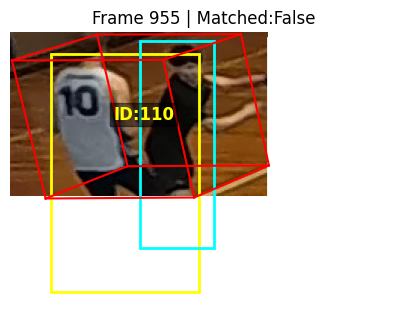

strict_match:True
[DEBUG] frame=954: 23 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[631.3102190192949, 760.6485534545842, 149.49779292579137, 111.4168140385649]
  [DEBUG] det=[985.2785949707031, 1045.413818359375, 106.34027, 285.46362], IoU=0.0000
  [DEBUG] det=[891.9154968261719, 872.070556640625, 119.13483, 214.78967], IoU=0.0000
  [DEBUG] det=[587.9168701171875, 1820.498291015625, 209.24048, 208.82153], IoU=0.0000
  [DEBUG] det=[960.4726257324219, 798.228271484375, 105.21832, 215.0597], IoU=0.0000
  [DEBUG] det=[3567.70458984375, 1375.9039916992188, 147.36914, 183.12854], IoU=0.0000
  [DEBUG] det=[2693.3685302734375, 1314.943603515625, 120.107666, 291.25854], IoU=0.0000
  [DEBUG] det=[638.7237548828125, 786.0738525390625, 88.847046, 165.21814], IoU=0.3224
  [DEBUG] det=[2547.86767578125, 779.927490234375, 74.384766, 177.48486], IoU=0.0000
  [DEBUG] det=[1633.4779663085938, 759.3466186523438, 61.857056, 177.81738], IoU=0.0000
  [DEBUG] det=[1320.5933227539062, 799.67193603515

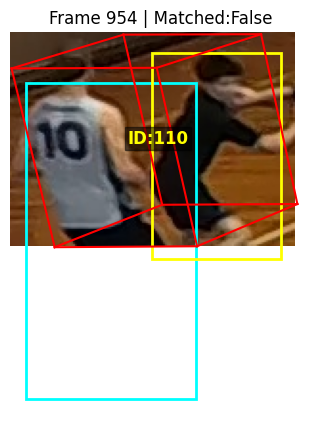

strict_match:True
[DEBUG] frame=953: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[647.9349473880393, 762.9836397869665, 131.75319284802367, 103.54443900909473]
  [DEBUG] det=[993.8489990234375, 1048.30126953125, 115.12207, 282.03638], IoU=0.0000
  [DEBUG] det=[587.2298583984375, 1820.4169921875, 209.8518, 209.15845], IoU=0.0000
  [DEBUG] det=[2698.1998291015625, 1309.9757690429688, 125.139404, 299.47375], IoU=0.0000
  [DEBUG] det=[3567.111328125, 1377.8334350585938, 147.52734, 182.28186], IoU=0.0000
  [DEBUG] det=[1635.350341796875, 761.52392578125, 61.320557, 180.09961], IoU=0.0000
  [DEBUG] det=[2523.271728515625, 781.4117431640625, 90.59326, 171.83533], IoU=0.0000
  [DEBUG] det=[1321.244384765625, 787.9949340820312, 66.9104, 174.8899], IoU=0.0000
  [DEBUG] det=[1425.099365234375, 772.346923828125, 81.784424, 181.87097], IoU=0.0000
  [DEBUG] det=[382.16424560546875, 1821.92431640625, 182.98059, 177.52881], IoU=0.0000
  [DEBUG] det=[973.2007446289062, 798.1612548828125, 119.

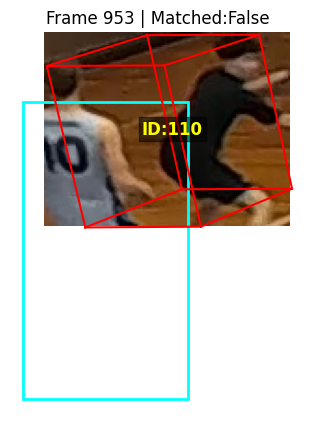

strict_match:True
[DEBUG] frame=952: 23 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[650.7097028715211, 762.8352251338679, 130.20580613476773, 103.43497263985819]
  [DEBUG] det=[586.7789001464844, 1820.26708984375, 210.4378, 210.2146], IoU=0.0000
  [DEBUG] det=[2697.345703125, 1304.911865234375, 132.25635, 294.20435], IoU=0.0000
  [DEBUG] det=[3569.555419921875, 1376.8377075195312, 146.2251, 183.04626], IoU=0.0000
  [DEBUG] det=[1000.6165771484375, 1045.253662109375, 138.25903, 285.93872], IoU=0.0000
  [DEBUG] det=[986.257080078125, 799.8981018066406, 111.991455, 199.79755], IoU=0.0000
  [DEBUG] det=[1638.9539794921875, 764.375244140625, 54.98584, 177.01611], IoU=0.0000
  [DEBUG] det=[629.4266662597656, 799.5172119140625, 83.413025, 167.44629], IoU=0.1781
  [DEBUG] det=[1333.548095703125, 782.0359497070312, 60.22632, 171.46912], IoU=0.0000
  [DEBUG] det=[1433.115234375, 778.1216735839844, 71.626465, 181.94733], IoU=0.0000
  [DEBUG] det=[3409.03125, 1392.2483520507812, 180.0249, 

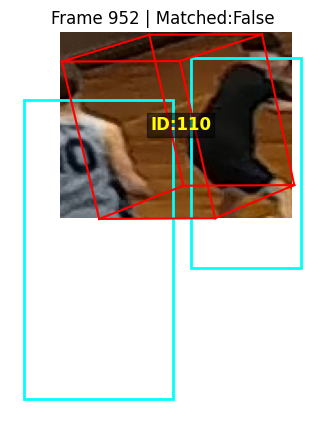

strict_match:True
[DEBUG] frame=951: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[676.4464400181073, 760.393246976092, 127.76072815545672, 101.08274702181097]
  [DEBUG] det=[1012.09375, 1044.5818481445312, 152.34229, 290.36023], IoU=0.0000
  [DEBUG] det=[2696.60400390625, 1303.671875, 140.65381, 294.05957], IoU=0.0000
  [DEBUG] det=[587.2231140136719, 1819.6036376953125, 209.22882, 209.01782], IoU=0.0000
  [DEBUG] det=[3567.293701171875, 1377.3756713867188, 147.0498, 182.87952], IoU=0.0000
  [DEBUG] det=[385.18377685546875, 1822.25830078125, 181.22937, 180.5669], IoU=0.0000
  [DEBUG] det=[1640.439697265625, 763.2554016113281, 55.11914, 178.91913], IoU=0.0000
  [DEBUG] det=[1345.7809448242188, 779.0886840820312, 55.518677, 175.73914], IoU=0.0000
  [DEBUG] det=[998.384033203125, 796.3052978515625, 109.03784, 202.17737], IoU=0.0000
  [DEBUG] det=[3407.0126953125, 1390.5842895507812, 177.46729, 176.58435], IoU=0.0000
  [DEBUG] det=[1441.8584594726562, 778.7237243652344, 71.28113,

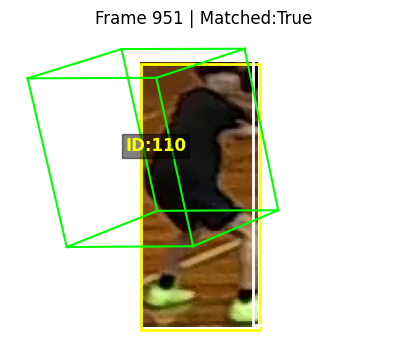

strict_match:True
[DEBUG] frame=956: 23 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[710.5628763570928, 760.6536488429673, 168.56303578380948, 115.91099651856268]
  [DEBUG] det=[970.1496887207031, 1046.007080078125, 122.86957, 284.48926], IoU=0.0000
  [DEBUG] det=[587.4039611816406, 1819.8240966796875, 208.3681, 208.11255], IoU=0.0000
  [DEBUG] det=[3566.5318603515625, 1376.903076171875, 148.86987, 183.44214], IoU=0.0000
  [DEBUG] det=[3411.226318359375, 1391.169677734375, 172.75049, 177.20508], IoU=0.0000
  [DEBUG] det=[2564.93701171875, 781.8715209960938, 70.395996, 151.48718], IoU=0.0000
  [DEBUG] det=[384.65049743652344, 1822.6380615234375, 181.17142, 178.98413], IoU=0.0000
  [DEBUG] det=[1634.9476318359375, 759.3740844726562, 54.66284, 175.68274], IoU=0.0000
  [DEBUG] det=[1885.7083740234375, 697.5699462890625, 41.260986, 136.68713], IoU=0.0000
  [DEBUG] det=[936.500244140625, 804.3821105957031, 102.9928, 219.62323], IoU=0.0000
  [DEBUG] det=[843.0716247558594, 863.40026855

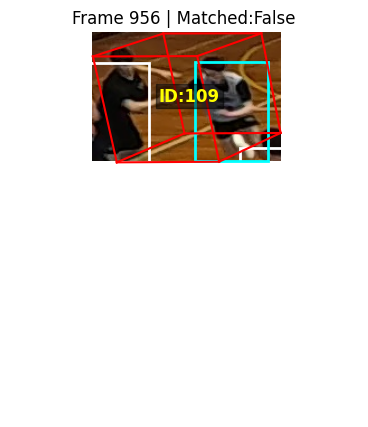

strict_match:True
[DEBUG] frame=955: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[718.6233924235439, 761.5587262303475, 167.24698969717792, 107.47702639375893]
  [DEBUG] det=[977.5395202636719, 1042.9990234375, 113.565, 288.39917], IoU=0.0000
  [DEBUG] det=[586.6802978515625, 1820.02880859375, 209.36133, 207.79468], IoU=0.0000
  [DEBUG] det=[3566.501953125, 1376.8490600585938, 148.41064, 184.01233], IoU=0.0000
  [DEBUG] det=[944.3354797363281, 800.0643310546875, 98.16913, 227.60706], IoU=0.0000
  [DEBUG] det=[858.1682739257812, 869.4898681640625, 146.37488, 217.73914], IoU=0.0000
  [DEBUG] det=[1324.3919677734375, 801.0210571289062, 59.80078, 163.6919], IoU=0.0000
  [DEBUG] det=[3405.296630859375, 1391.1842651367188, 178.16895, 177.60706], IoU=0.0000
  [DEBUG] det=[384.38719177246094, 1822.18505859375, 181.16788, 179.90405], IoU=0.0000
  [DEBUG] det=[1633.6796875, 759.24609375, 61.393066, 175.34839], IoU=0.0000
  [DEBUG] det=[1886.070068359375, 698.5328369140625, 40.913086, 1

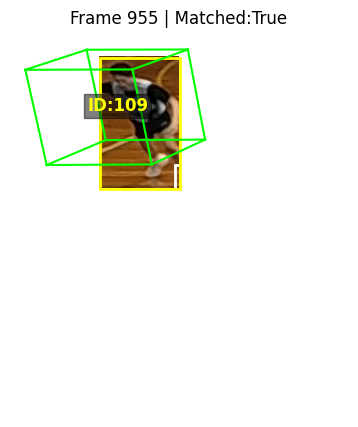

strict_match:True
[DEBUG] frame=971: 12 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1744.9815167199463, 858.3832633218718, 195.02439893020914, 236.130864284322]
  [DEBUG] det=[995.5631713867188, 837.1434020996094, 82.27844, 270.41583], IoU=0.0000
  [DEBUG] det=[2104.8533935546875, 778.6569213867188, 84.454346, 230.99634], IoU=0.0000
  [DEBUG] det=[1612.2382202148438, 743.4063720703125, 68.50305, 182.5481], IoU=0.0000
  [DEBUG] det=[1363.595458984375, 825.8200988769531, 82.20044, 234.633], IoU=0.0000
  [DEBUG] det=[787.455322265625, 700.521728515625, 56.466797, 186.20288], IoU=0.0000
  [DEBUG] det=[1413.16015625, 712.3873291015625, 72.821045, 137.19873], IoU=0.0000
  [DEBUG] det=[1656.19580078125, 891.5797119140625, 153.1018, 273.34204], IoU=0.1744
  [DEBUG] det=[2304.9935302734375, 797.1851806640625, 70.73364, 160.15979], IoU=0.0000
  [DEBUG] det=[2194.281005859375, 791.718017578125, 134.81396, 209.52539], IoU=0.0000
  [DEBUG] det=[1746.7987060546875, 868.72412109375, 99.788086

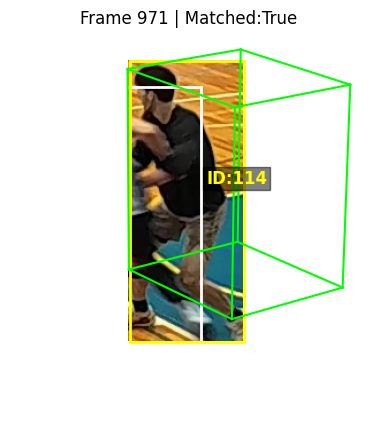

strict_match:True
[DEBUG] frame=971: 12 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1001.1693207361491, 832.7699413975607, 168.70110625173243, 218.99097627749154]
  [DEBUG] det=[995.5631713867188, 837.1434020996094, 82.27844, 270.41583], IoU=0.3850
  [DEBUG] det=[2104.8533935546875, 778.6569213867188, 84.454346, 230.99634], IoU=0.0000
  [DEBUG] det=[1612.2382202148438, 743.4063720703125, 68.50305, 182.5481], IoU=0.0000
  [DEBUG] det=[1363.595458984375, 825.8200988769531, 82.20044, 234.633], IoU=0.0000
  [DEBUG] det=[787.455322265625, 700.521728515625, 56.466797, 186.20288], IoU=0.0000
  [DEBUG] det=[1413.16015625, 712.3873291015625, 72.821045, 137.19873], IoU=0.0000
  [DEBUG] det=[1656.19580078125, 891.5797119140625, 153.1018, 273.34204], IoU=0.0000
  [DEBUG] det=[2304.9935302734375, 797.1851806640625, 70.73364, 160.15979], IoU=0.0000
  [DEBUG] det=[2194.281005859375, 791.718017578125, 134.81396, 209.52539], IoU=0.0000
  [DEBUG] det=[1746.7987060546875, 868.72412109375, 99.7880

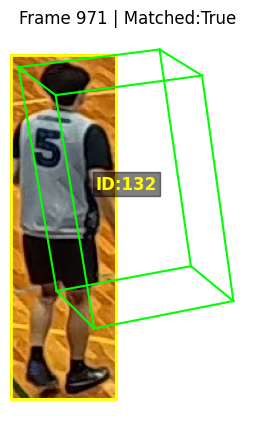

strict_match:True
[DEBUG] frame=980: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[647.8155633172719, 787.8940822874347, 164.07796784482593, 171.11468049412986]
  [DEBUG] det=[586.8015747070312, 1820.2448120117188, 208.80579, 206.97327], IoU=0.0000
  [DEBUG] det=[724.1121520996094, 790.4915771484375, 80.125305, 196.5835], IoU=0.4453
  [DEBUG] det=[3566.501220703125, 1377.3262939453125, 149.35693, 181.98193], IoU=0.0000
  [DEBUG] det=[815.004150390625, 1060.1355590820312, 127.323, 300.1317], IoU=0.0000
  [DEBUG] det=[1886.11083984375, 698.5676879882812, 40.801025, 135.52771], IoU=0.0000
  [DEBUG] det=[383.85150146484375, 1822.614990234375, 181.38788, 179.58838], IoU=0.0000
  [DEBUG] det=[2427.0394287109375, 1345.2915649414062, 126.39673, 297.307], IoU=0.0000
  [DEBUG] det=[1309.3515625, 786.9186401367188, 90.50122, 170.15222], IoU=0.0000
  [DEBUG] det=[560.8788757324219, 859.244873046875, 94.00568, 243.28894], IoU=0.0140
  [DEBUG] det=[634.998291015625, 930.9547729492188, 131.0

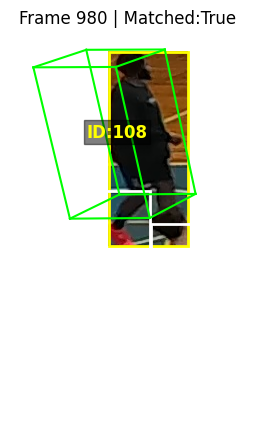

strict_match:True
[DEBUG] frame=995: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[466.0815361872583, 880.5968356663409, 238.9799901816009, 209.36713888438294]
  [DEBUG] det=[585.7359313964844, 1822.2674560546875, 210.45465, 207.34497], IoU=0.0000
  [DEBUG] det=[674.56982421875, 1035.30224609375, 181.75232, 331.79883], IoU=0.0153
  [DEBUG] det=[1360.9664916992188, 732.2490234375, 80.10022, 157.14331], IoU=0.0000
  [DEBUG] det=[3568.24658203125, 1377.5433959960938, 148.4707, 182.23987], IoU=0.0000
  [DEBUG] det=[383.07228088378906, 1821.9228515625, 183.04355, 180.76611], IoU=0.0000
  [DEBUG] det=[1885.8651123046875, 697.6972351074219, 40.825928, 136.09552], IoU=0.0000
  [DEBUG] det=[887.5830688476562, 742.5075073242188, 97.787476, 146.15039], IoU=0.0000
  [DEBUG] det=[3409.6553955078125, 1392.1627807617188, 178.28394, 178.68665], IoU=0.0000
  [DEBUG] det=[727.0977783203125, 880.4631652832031, 132.74182, 216.84418], IoU=0.0000
  [DEBUG] det=[1587.4134521484375, 787.3341064453125

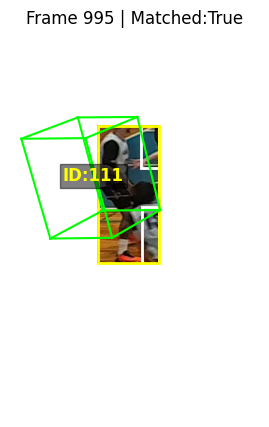

strict_match:True
[DEBUG] frame=996: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[623.7156684346764, 857.5149955893414, 225.68662904020061, 194.2138397829433]
  [DEBUG] det=[716.0355224609375, 1050.546875, 131.41272, 308.2556], IoU=0.0018
  [DEBUG] det=[587.1659851074219, 1819.0777587890625, 208.73126, 210.46436], IoU=0.0000
  [DEBUG] det=[2602.77783203125, 1331.5802612304688, 116.74902, 231.01282], IoU=0.0000
  [DEBUG] det=[1373.53076171875, 725.5859375, 65.68237, 161.41858], IoU=0.0000
  [DEBUG] det=[727.1875, 879.2917175292969, 121.13086, 212.32281], IoU=0.4292
  [DEBUG] det=[3568.130859375, 1377.424560546875, 148.63184, 182.34595], IoU=0.0000
  [DEBUG] det=[1885.9830322265625, 697.4447021484375, 40.686035, 136.97937], IoU=0.0000
  [DEBUG] det=[1586.3836669921875, 791.975341796875, 49.697754, 162.19922], IoU=0.0000
  [DEBUG] det=[383.338134765625, 1822.9452514648438, 182.22333, 178.01038], IoU=0.0000
  [DEBUG] det=[675.2363891601562, 765.6165161132812, 66.94629, 185.93335]

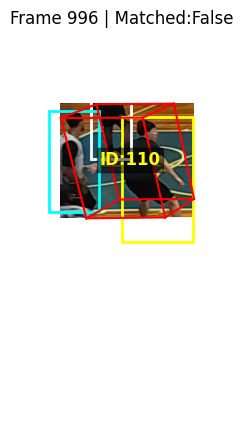

strict_match:True
[DEBUG] frame=995: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[634.4765264184523, 889.1591194823501, 221.60085139434204, 164.40431874689523]
  [DEBUG] det=[585.7359313964844, 1822.2674560546875, 210.45465, 207.34497], IoU=0.0000
  [DEBUG] det=[674.56982421875, 1035.30224609375, 181.75232, 331.79883], IoU=0.0355
  [DEBUG] det=[1360.9664916992188, 732.2490234375, 80.10022, 157.14331], IoU=0.0000
  [DEBUG] det=[3568.24658203125, 1377.5433959960938, 148.4707, 182.23987], IoU=0.0000
  [DEBUG] det=[383.07228088378906, 1821.9228515625, 183.04355, 180.76611], IoU=0.0000
  [DEBUG] det=[1885.8651123046875, 697.6972351074219, 40.825928, 136.09552], IoU=0.0000
  [DEBUG] det=[887.5830688476562, 742.5075073242188, 97.787476, 146.15039], IoU=0.0000
  [DEBUG] det=[3409.6553955078125, 1392.1627807617188, 178.28394, 178.68665], IoU=0.0000
  [DEBUG] det=[727.0977783203125, 880.4631652832031, 132.74182, 216.84418], IoU=0.4818
  [DEBUG] det=[1587.4134521484375, 787.334106445312

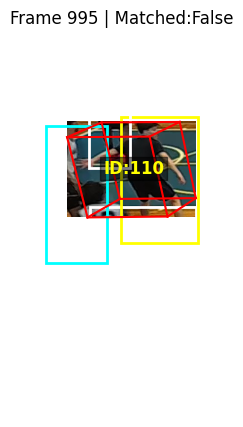

strict_match:True
[DEBUG] frame=994: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[640.7445002505174, 899.5849537490965, 249.74616415927653, 156.69238754341336]
  [DEBUG] det=[587.46630859375, 1820.8333740234375, 207.36646, 207.89648], IoU=0.0000
  [DEBUG] det=[3568.31787109375, 1375.854248046875, 148.56885, 182.70264], IoU=0.0000
  [DEBUG] det=[722.4913024902344, 1042.022705078125, 134.8089, 324.4978], IoU=0.0237
  [DEBUG] det=[1591.169189453125, 786.1887817382812, 48.398438, 155.28918], IoU=0.0000
  [DEBUG] det=[3410.3321533203125, 1391.01611328125, 175.27808, 176.93335], IoU=0.0000
  [DEBUG] det=[715.18701171875, 883.0837707519531, 161.77307, 219.74115], IoU=0.5138
  [DEBUG] det=[1360.8570556640625, 734.9642944335938, 76.710205, 155.25366], IoU=0.0000
  [DEBUG] det=[382.1392822265625, 1822.454345703125, 183.8888, 177.07983], IoU=0.0000
  [DEBUG] det=[1885.979736328125, 697.6268920898438, 40.686035, 135.2179], IoU=0.0000
  [DEBUG] det=[911.5528869628906, 741.8790893554688, 8

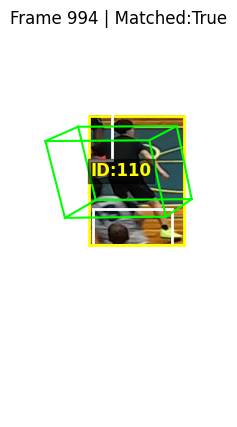

strict_match:True
[DEBUG] frame=998: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[526.3787610393817, 873.9707732327394, 181.29278650360993, 194.85350069828735]
  [DEBUG] det=[705.9559326171875, 1049.010009765625, 123.240234, 302.45972], IoU=0.0005
  [DEBUG] det=[586.7992248535156, 1819.0576171875, 208.54193, 210.16699], IoU=0.0000
  [DEBUG] det=[474.2502746582031, 1012.3594970703125, 231.37811, 261.71826], IoU=0.1180
  [DEBUG] det=[3569.04345703125, 1378.1220703125, 149.20605, 181.39966], IoU=0.0000
  [DEBUG] det=[382.76612854003906, 1822.22509765625, 183.27744, 180.06128], IoU=0.0000
  [DEBUG] det=[3406.510986328125, 1390.9088745117188, 184.88086, 178.21008], IoU=0.0000
  [DEBUG] det=[1885.78076171875, 697.3751220703125, 40.791016, 136.6051], IoU=0.0000
  [DEBUG] det=[2612.996337890625, 1335.80029296875, 121.924805, 235.55884], IoU=0.0000
  [DEBUG] det=[1184.763916015625, 802.784912109375, 83.59985, 168.29773], IoU=0.0000
  [DEBUG] det=[1385.07958984375, 721.2337951660156, 5

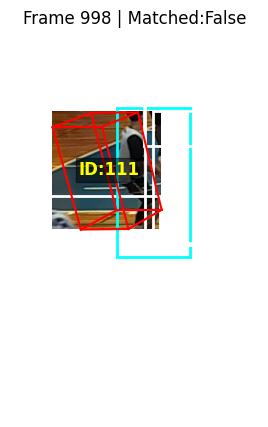

strict_match:True
[DEBUG] frame=997: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[511.34774887164303, 883.7777315480304, 188.77922864222614, 192.29245582506348]
  [DEBUG] det=[714.0917053222656, 1048.2122192382812, 119.630554, 305.20203], IoU=0.0000
  [DEBUG] det=[587.4661865234375, 1819.6732177734375, 209.11243, 209.76782], IoU=0.0000
  [DEBUG] det=[3565.59716796875, 1377.9075317382812, 151.32764, 182.89001], IoU=0.0000
  [DEBUG] det=[382.39990234375, 1822.23779296875, 183.00842, 180.06885], IoU=0.0000
  [DEBUG] det=[2608.6455078125, 1333.242431640625, 117.26123, 230.62354], IoU=0.0000
  [DEBUG] det=[709.1244201660156, 887.1059265136719, 141.62274, 206.96808], IoU=0.0000
  [DEBUG] det=[3405.0887451171875, 1390.9119873046875, 180.0022, 178.92627], IoU=0.0000
  [DEBUG] det=[1885.889892578125, 697.535888671875, 40.776123, 136.69482], IoU=0.0000
  [DEBUG] det=[1380.997314453125, 718.135986328125, 59.158936, 169.99329], IoU=0.0000
  [DEBUG] det=[531.3775939941406, 986.10723876953

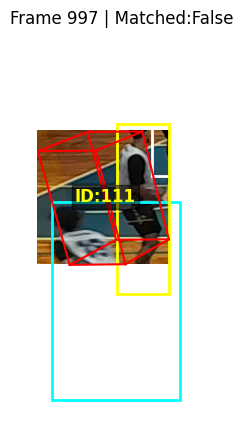

strict_match:True
[DEBUG] frame=996: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[500.88862761468454, 872.3803448683309, 201.41229316829867, 204.59771984920962]
  [DEBUG] det=[716.0355224609375, 1050.546875, 131.41272, 308.2556], IoU=0.0000
  [DEBUG] det=[587.1659851074219, 1819.0777587890625, 208.73126, 210.46436], IoU=0.0000
  [DEBUG] det=[2602.77783203125, 1331.5802612304688, 116.74902, 231.01282], IoU=0.0000
  [DEBUG] det=[1373.53076171875, 725.5859375, 65.68237, 161.41858], IoU=0.0000
  [DEBUG] det=[727.1875, 879.2917175292969, 121.13086, 212.32281], IoU=0.0000
  [DEBUG] det=[3568.130859375, 1377.424560546875, 148.63184, 182.34595], IoU=0.0000
  [DEBUG] det=[1885.9830322265625, 697.4447021484375, 40.686035, 136.97937], IoU=0.0000
  [DEBUG] det=[1586.3836669921875, 791.975341796875, 49.697754, 162.19922], IoU=0.0000
  [DEBUG] det=[383.338134765625, 1822.9452514648438, 182.22333, 178.01038], IoU=0.0000
  [DEBUG] det=[675.2363891601562, 765.6165161132812, 66.94629, 185.9333

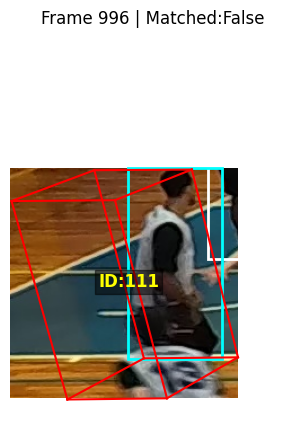

strict_match:True
[DEBUG] frame=995: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[466.0815361872583, 880.5968356663409, 238.9799901816009, 209.36713888438294]
  [DEBUG] det=[585.7359313964844, 1822.2674560546875, 210.45465, 207.34497], IoU=0.0000
  [DEBUG] det=[674.56982421875, 1035.30224609375, 181.75232, 331.79883], IoU=0.0153
  [DEBUG] det=[1360.9664916992188, 732.2490234375, 80.10022, 157.14331], IoU=0.0000
  [DEBUG] det=[3568.24658203125, 1377.5433959960938, 148.4707, 182.23987], IoU=0.0000
  [DEBUG] det=[383.07228088378906, 1821.9228515625, 183.04355, 180.76611], IoU=0.0000
  [DEBUG] det=[1885.8651123046875, 697.6972351074219, 40.825928, 136.09552], IoU=0.0000
  [DEBUG] det=[887.5830688476562, 742.5075073242188, 97.787476, 146.15039], IoU=0.0000
  [DEBUG] det=[3409.6553955078125, 1392.1627807617188, 178.28394, 178.68665], IoU=0.0000
  [DEBUG] det=[727.0977783203125, 880.4631652832031, 132.74182, 216.84418], IoU=0.0000
  [DEBUG] det=[1587.4134521484375, 787.3341064453125

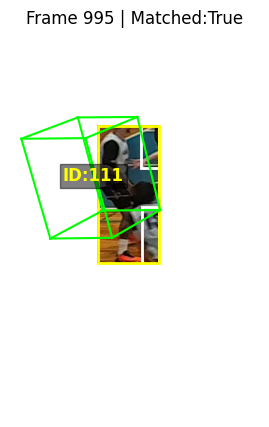

strict_match:True
[DEBUG] frame=999: 23 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[640.4984933639842, 918.1475599479315, 173.9683202428305, 120.18615493918924]
  [DEBUG] det=[697.5474853515625, 1049.4777221679688, 132.22559, 306.74524], IoU=0.0000
  [DEBUG] det=[587.4315185546875, 1819.1898193359375, 208.73718, 210.33911], IoU=0.0000
  [DEBUG] det=[419.69000244140625, 1007.4445190429688, 135.47058, 265.27014], IoU=0.0000
  [DEBUG] det=[384.3211669921875, 1822.4531860351562, 181.38116, 182.36902], IoU=0.0000
  [DEBUG] det=[3566.6273193359375, 1377.83837890625, 150.97778, 182.5459], IoU=0.0000
  [DEBUG] det=[3407.921630859375, 1391.1875, 177.02197, 177.11792], IoU=0.0000
  [DEBUG] det=[1885.9493408203125, 697.5780029296875, 40.74756, 135.68701], IoU=0.0000
  [DEBUG] det=[2618.23046875, 1337.4789428710938, 123.666504, 240.93811], IoU=0.0000
  [DEBUG] det=[1916.71875, 1729.154296875, 189.92432, 271.29346], IoU=0.0000
  [DEBUG] det=[833.3904113769531, 1576.5138549804688, 207.10223,

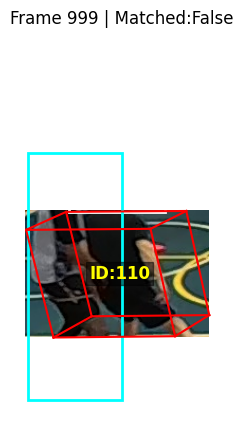

strict_match:True
[DEBUG] frame=998: 26 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[621.3271156352, 865.068866262807, 195.69808204000037, 183.78623627671573]
  [DEBUG] det=[705.9559326171875, 1049.010009765625, 123.240234, 302.45972], IoU=0.0000
  [DEBUG] det=[586.7992248535156, 1819.0576171875, 208.54193, 210.16699], IoU=0.0000
  [DEBUG] det=[474.2502746582031, 1012.3594970703125, 231.37811, 261.71826], IoU=0.0329
  [DEBUG] det=[3569.04345703125, 1378.1220703125, 149.20605, 181.39966], IoU=0.0000
  [DEBUG] det=[382.76612854003906, 1822.22509765625, 183.27744, 180.06128], IoU=0.0000
  [DEBUG] det=[3406.510986328125, 1390.9088745117188, 184.88086, 178.21008], IoU=0.0000
  [DEBUG] det=[1885.78076171875, 697.3751220703125, 40.791016, 136.6051], IoU=0.0000
  [DEBUG] det=[2612.996337890625, 1335.80029296875, 121.924805, 235.55884], IoU=0.0000
  [DEBUG] det=[1184.763916015625, 802.784912109375, 83.59985, 168.29773], IoU=0.0000
  [DEBUG] det=[1385.07958984375, 721.2337951660156, 56.69

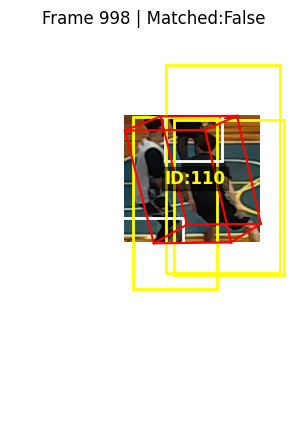

strict_match:True
[DEBUG] frame=997: 24 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[628.5070936846892, 868.9541204123644, 196.26498243130868, 179.93951761906453]
  [DEBUG] det=[714.0917053222656, 1048.2122192382812, 119.630554, 305.20203], IoU=0.0011
  [DEBUG] det=[587.4661865234375, 1819.6732177734375, 209.11243, 209.76782], IoU=0.0000
  [DEBUG] det=[3565.59716796875, 1377.9075317382812, 151.32764, 182.89001], IoU=0.0000
  [DEBUG] det=[382.39990234375, 1822.23779296875, 183.00842, 180.06885], IoU=0.0000
  [DEBUG] det=[2608.6455078125, 1333.242431640625, 117.26123, 230.62354], IoU=0.0000
  [DEBUG] det=[709.1244201660156, 887.1059265136719, 141.62274, 206.96808], IoU=0.4075
  [DEBUG] det=[3405.0887451171875, 1390.9119873046875, 180.0022, 178.92627], IoU=0.0000
  [DEBUG] det=[1885.889892578125, 697.535888671875, 40.776123, 136.69482], IoU=0.0000
  [DEBUG] det=[1380.997314453125, 718.135986328125, 59.158936, 169.99329], IoU=0.0000
  [DEBUG] det=[531.3775939941406, 986.107238769531

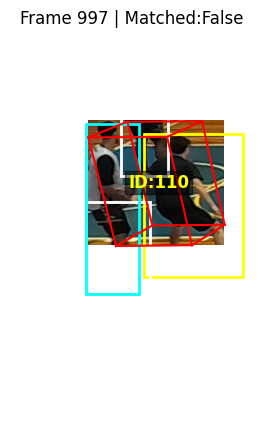

strict_match:True
[DEBUG] frame=996: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[623.7156684346764, 857.5149955893414, 225.68662904020061, 194.2138397829433]
  [DEBUG] det=[716.0355224609375, 1050.546875, 131.41272, 308.2556], IoU=0.0018
  [DEBUG] det=[587.1659851074219, 1819.0777587890625, 208.73126, 210.46436], IoU=0.0000
  [DEBUG] det=[2602.77783203125, 1331.5802612304688, 116.74902, 231.01282], IoU=0.0000
  [DEBUG] det=[1373.53076171875, 725.5859375, 65.68237, 161.41858], IoU=0.0000
  [DEBUG] det=[727.1875, 879.2917175292969, 121.13086, 212.32281], IoU=0.4292
  [DEBUG] det=[3568.130859375, 1377.424560546875, 148.63184, 182.34595], IoU=0.0000
  [DEBUG] det=[1885.9830322265625, 697.4447021484375, 40.686035, 136.97937], IoU=0.0000
  [DEBUG] det=[1586.3836669921875, 791.975341796875, 49.697754, 162.19922], IoU=0.0000
  [DEBUG] det=[383.338134765625, 1822.9452514648438, 182.22333, 178.01038], IoU=0.0000
  [DEBUG] det=[675.2363891601562, 765.6165161132812, 66.94629, 185.93335]

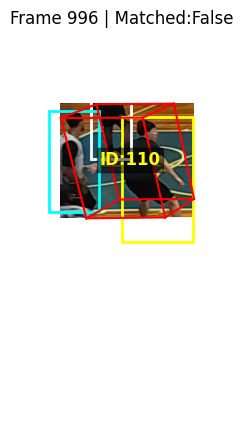

strict_match:True
[DEBUG] frame=995: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[634.4765264184523, 889.1591194823501, 221.60085139434204, 164.40431874689523]
  [DEBUG] det=[585.7359313964844, 1822.2674560546875, 210.45465, 207.34497], IoU=0.0000
  [DEBUG] det=[674.56982421875, 1035.30224609375, 181.75232, 331.79883], IoU=0.0355
  [DEBUG] det=[1360.9664916992188, 732.2490234375, 80.10022, 157.14331], IoU=0.0000
  [DEBUG] det=[3568.24658203125, 1377.5433959960938, 148.4707, 182.23987], IoU=0.0000
  [DEBUG] det=[383.07228088378906, 1821.9228515625, 183.04355, 180.76611], IoU=0.0000
  [DEBUG] det=[1885.8651123046875, 697.6972351074219, 40.825928, 136.09552], IoU=0.0000
  [DEBUG] det=[887.5830688476562, 742.5075073242188, 97.787476, 146.15039], IoU=0.0000
  [DEBUG] det=[3409.6553955078125, 1392.1627807617188, 178.28394, 178.68665], IoU=0.0000
  [DEBUG] det=[727.0977783203125, 880.4631652832031, 132.74182, 216.84418], IoU=0.4818
  [DEBUG] det=[1587.4134521484375, 787.334106445312

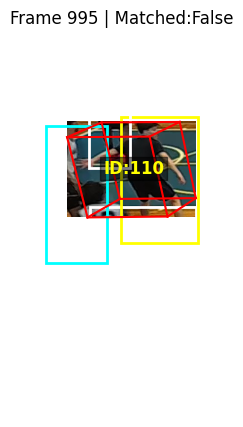

strict_match:True
[DEBUG] frame=994: 22 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[640.7445002505174, 899.5849537490965, 249.74616415927653, 156.69238754341336]
  [DEBUG] det=[587.46630859375, 1820.8333740234375, 207.36646, 207.89648], IoU=0.0000
  [DEBUG] det=[3568.31787109375, 1375.854248046875, 148.56885, 182.70264], IoU=0.0000
  [DEBUG] det=[722.4913024902344, 1042.022705078125, 134.8089, 324.4978], IoU=0.0237
  [DEBUG] det=[1591.169189453125, 786.1887817382812, 48.398438, 155.28918], IoU=0.0000
  [DEBUG] det=[3410.3321533203125, 1391.01611328125, 175.27808, 176.93335], IoU=0.0000
  [DEBUG] det=[715.18701171875, 883.0837707519531, 161.77307, 219.74115], IoU=0.5138
  [DEBUG] det=[1360.8570556640625, 734.9642944335938, 76.710205, 155.25366], IoU=0.0000
  [DEBUG] det=[382.1392822265625, 1822.454345703125, 183.8888, 177.07983], IoU=0.0000
  [DEBUG] det=[1885.979736328125, 697.6268920898438, 40.686035, 135.2179], IoU=0.0000
  [DEBUG] det=[911.5528869628906, 741.8790893554688, 8

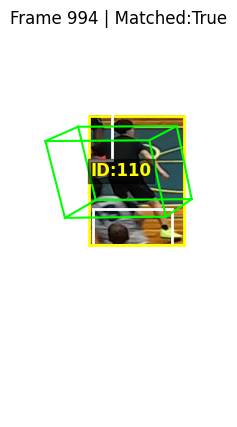

strict_match:True
[DEBUG] frame=1013: 16 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1941.4337527891203, 668.2862907853514, 100.35558454394436, 141.96786917947065]
  [DEBUG] det=[1461.8873901367188, 856.95703125, 99.786255, 275.5459], IoU=0.0000
  [DEBUG] det=[3335.3818359375, 900.94921875, 145.36377, 246.03223], IoU=0.0000
  [DEBUG] det=[2520.3876953125, 781.307861328125, 154.19629, 206.5979], IoU=0.0000
  [DEBUG] det=[2721.02587890625, 690.1209716796875, 115.86328, 198.57239], IoU=0.0000
  [DEBUG] det=[3143.531982421875, 839.3270263671875, 111.6416, 219.22046], IoU=0.0000
  [DEBUG] det=[1894.751953125, 688.1795349121094, 71.90991, 151.54987], IoU=0.1396
  [DEBUG] det=[2445.1663818359375, 654.4648742675781, 66.42505, 169.34637], IoU=0.0000
  [DEBUG] det=[2243.375, 820.7069091796875, 106.1792, 275.04578], IoU=0.0000
  [DEBUG] det=[2604.913330078125, 657.3848876953125, 62.910645, 135.84595], IoU=0.0000
  [DEBUG] det=[2258.2867431640625, 716.6641845703125, 121.355225, 136.51685],

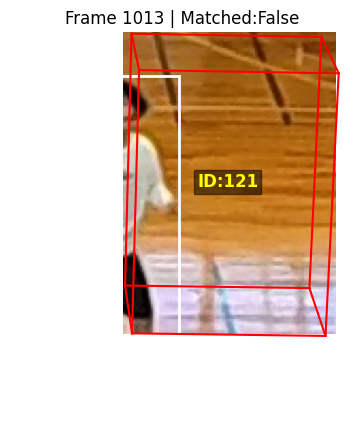

strict_match:True
[DEBUG] frame=1012: 21 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1952.4639298030384, 679.1235526201806, 91.52129937115319, 131.9337697105559]
  [DEBUG] det=[3335.45751953125, 908.9373779296875, 147.06738, 235.27661], IoU=0.0000
  [DEBUG] det=[1461.82568359375, 857.397216796875, 99.985596, 275.3866], IoU=0.0000
  [DEBUG] det=[2540.6414794921875, 775.6729736328125, 145.19849, 212.76721], IoU=0.0000
  [DEBUG] det=[3142.581298828125, 843.4366455078125, 111.82471, 218.08154], IoU=0.0000
  [DEBUG] det=[1913.866943359375, 683.9035339355469, 65.150635, 153.07501], IoU=0.1808
  [DEBUG] det=[2750.3505859375, 688.271240234375, 91.9082, 189.84424], IoU=0.0000
  [DEBUG] det=[2264.9775390625, 820.9786376953125, 110.87402, 241.20154], IoU=0.0000
  [DEBUG] det=[2601.9293212890625, 656.0904846191406, 63.58081, 136.8598], IoU=0.0000
  [DEBUG] det=[2259.0228271484375, 718.0197143554688, 132.0354, 131.1372], IoU=0.0000
  [DEBUG] det=[2455.317138671875, 659.8809814453125, 60.555

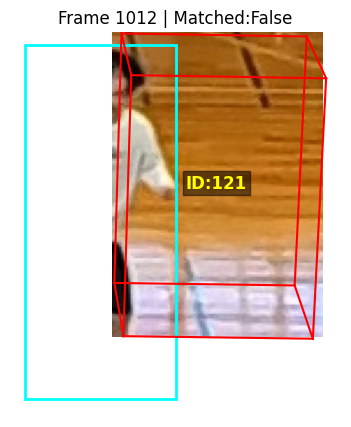

strict_match:True
[DEBUG] frame=1011: 19 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1958.7479460348586, 678.3497496083678, 82.9816180100504, 134.35766489244656]
  [DEBUG] det=[1464.701416015625, 858.7663269042969, 97.20923, 274.26642], IoU=0.0000
  [DEBUG] det=[3334.30029296875, 911.3342895507812, 148.15869, 232.91931], IoU=0.0000
  [DEBUG] det=[2571.86083984375, 774.860595703125, 125.11084, 212.85681], IoU=0.0000
  [DEBUG] det=[2773.0096435546875, 685.7380676269531, 84.09595, 192.07709], IoU=0.0000
  [DEBUG] det=[1925.962646484375, 679.6736145019531, 68.77368, 147.23676], IoU=0.2904
  [DEBUG] det=[2276.8624267578125, 802.4698486328125, 98.57007, 270.93274], IoU=0.0000
  [DEBUG] det=[3142.72265625, 849.7591552734375, 113.17969, 211.59009], IoU=0.0000
  [DEBUG] det=[2601.5338134765625, 652.5939636230469, 55.7937, 116.40216], IoU=0.0000
  [DEBUG] det=[2468.1494140625, 652.2872314453125, 53.893555, 129.47461], IoU=0.0000
  [DEBUG] det=[2712.0821533203125, 827.6077880859375, 65.01

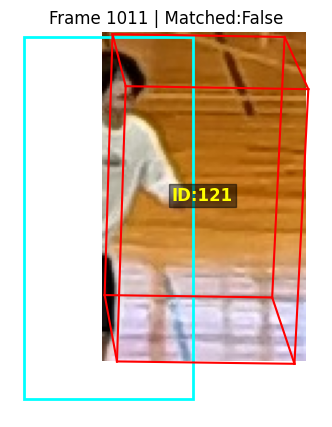

strict_match:True
[DEBUG] frame=1010: 18 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1970.353479581302, 677.1420449766704, 68.16038291908603, 131.35088096531877]
  [DEBUG] det=[1464.544677734375, 858.7908020019531, 96.96875, 274.35345], IoU=0.0000
  [DEBUG] det=[3336.9638671875, 912.06640625, 141.64453, 231.99146], IoU=0.0000
  [DEBUG] det=[2592.9439697265625, 771.205810546875, 101.19507, 216.09485], IoU=0.0000
  [DEBUG] det=[2783.6590576171875, 685.5901184082031, 86.2229, 205.06659], IoU=0.0000
  [DEBUG] det=[3141.75439453125, 841.972412109375, 125.78467, 220.86328], IoU=0.0000
  [DEBUG] det=[2276.943359375, 801.3044738769531, 118.82959, 274.56854], IoU=0.0000
  [DEBUG] det=[1933.60986328125, 681.171630859375, 67.803955, 149.6333], IoU=0.2611
  [DEBUG] det=[2597.4588623046875, 654.0644836425781, 51.116455, 97.417175], IoU=0.0000
  [DEBUG] det=[2471.108642578125, 644.6650085449219, 60.965332, 142.95929], IoU=0.0000
  [DEBUG] det=[0.34564208984375, 771.59619140625, 81.13462, 173

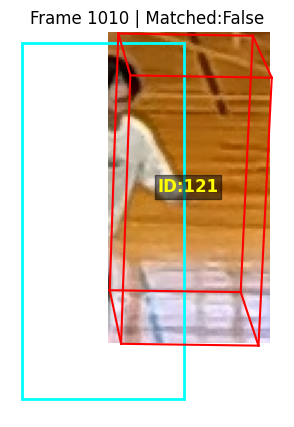

strict_match:True
[DEBUG] frame=1009: 18 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1969.3981740365582, 693.9237309756168, 60.32988204374169, 104.04887451792945]
  [DEBUG] det=[1462.270751953125, 857.5819091796875, 97.502686, 274.55615], IoU=0.0000
  [DEBUG] det=[3334.04443359375, 917.5762329101562, 143.23828, 227.03503], IoU=0.0000
  [DEBUG] det=[2603.1962890625, 767.8452758789062, 92.9458, 217.96692], IoU=0.0000
  [DEBUG] det=[3133.51025390625, 845.4219055175781, 133.56885, 211.1159], IoU=0.0000
  [DEBUG] det=[2793.8321533203125, 682.9979248046875, 85.48999, 199.19226], IoU=0.0000
  [DEBUG] det=[2477.366455078125, 648.2369689941406, 55.916016, 125.54535], IoU=0.0000
  [DEBUG] det=[1945.6614990234375, 679.2310791015625, 64.63403, 154.672], IoU=0.3540
  [DEBUG] det=[2280.8499755859375, 799.2630615234375, 104.303955, 275.78064], IoU=0.0000
  [DEBUG] det=[0.353363037109375, 771.7410888671875, 83.53813, 173.17407], IoU=0.0000
  [DEBUG] det=[2583.980712890625, 659.1773681640625, 5

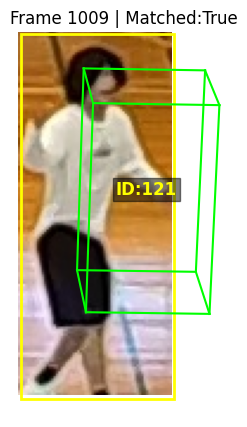

strict_match:True
[DEBUG] frame=1024: 25 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1649.935534714943, 778.7400995742489, 80.5669404827438, 142.37523662508454]
  [DEBUG] det=[64.10150909423828, 989.4724426269531, 209.72777, 294.43573], IoU=0.0000
  [DEBUG] det=[646.5081787109375, 1064.45703125, 154.6394, 293.80078], IoU=0.0000
  [DEBUG] det=[449.1759490966797, 883.8427734375, 170.51212, 225.24133], IoU=0.0000
  [DEBUG] det=[586.82568359375, 1820.17724609375, 209.38513, 210.09961], IoU=0.0000
  [DEBUG] det=[3568.109619140625, 1375.369140625, 146.8711, 184.09424], IoU=0.0000
  [DEBUG] det=[3409.944580078125, 1391.6492309570312, 177.47461, 178.5614], IoU=0.0000
  [DEBUG] det=[3711.609375, 935.8742370605469, 101.94141, 185.169], IoU=0.0000
  [DEBUG] det=[384.5657958984375, 1822.1802978515625, 180.81653, 177.71118], IoU=0.0000
  [DEBUG] det=[1643.7030029296875, 795.238525390625, 83.581055, 152.74268], IoU=0.6714
  [DEBUG] det=[1082.4414672851562, 828.2951965332031, 97.72156, 176.91

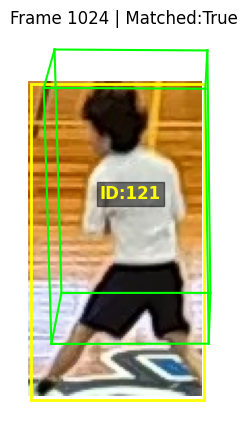

strict_match:True
[DEBUG] frame=1028: 11 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1608.380426071914, 741.3305370331402, 131.44043082192093, 116.59926088064822]
  [DEBUG] det=[1176.148193359375, 1077.6173095703125, 156.77002, 381.26733], IoU=0.0000
  [DEBUG] det=[1884.336669921875, 761.4318237304688, 112.77734, 250.81604], IoU=0.0000
  [DEBUG] det=[2341.81396484375, 789.7491455078125, 86.66748, 205.92102], IoU=0.0000
  [DEBUG] det=[1592.540283203125, 744.493896484375, 103.26367, 147.8899], IoU=0.4795
  [DEBUG] det=[784.7024841308594, 699.8710327148438, 60.631897, 186.3457], IoU=0.0000
  [DEBUG] det=[1604.40380859375, 953.5427551269531, 84.14502, 334.6164], IoU=0.0000
  [DEBUG] det=[2568.3580322265625, 806.0132446289062, 65.593506, 150.37683], IoU=0.0000
  [DEBUG] det=[1436.157958984375, 739.0972900390625, 86.759766, 179.63635], IoU=0.0000
  [DEBUG] det=[1503.5703735351562, 784.77978515625, 116.99695, 175.49963], IoU=0.0255
  [DEBUG] det=[1259.548095703125, 571.8070068359375, 

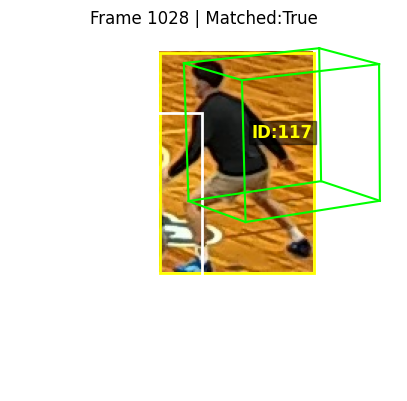

strict_match:True
[DEBUG] frame=1028: 25 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1051.077321370828, 803.0876700544512, 156.73309723922148, 172.72759141936262]
  [DEBUG] det=[626.7205810546875, 1066.0221557617188, 175.05115, 293.7433], IoU=0.0000
  [DEBUG] det=[66.43592834472656, 991.0491333007812, 155.86917, 282.5204], IoU=0.0000
  [DEBUG] det=[585.8289794921875, 1819.779052734375, 210.89368, 210.12231], IoU=0.0000
  [DEBUG] det=[495.96815490722656, 881.17236328125, 118.134125, 221.69421], IoU=0.0000
  [DEBUG] det=[3410.517333984375, 1391.5723266601562, 171.13037, 179.60046], IoU=0.0000
  [DEBUG] det=[3630.355224609375, 933.9718017578125, 142.66846, 171.17969], IoU=0.0000
  [DEBUG] det=[3567.23974609375, 1376.0839233398438, 146.71289, 184.69641], IoU=0.0000
  [DEBUG] det=[1582.6409912109375, 811.9522705078125, 90.052734, 135.62512], IoU=0.0000
  [DEBUG] det=[383.4981689453125, 1822.1212768554688, 181.92249, 180.99866], IoU=0.0000
  [DEBUG] det=[1119.638427734375, 809.954467

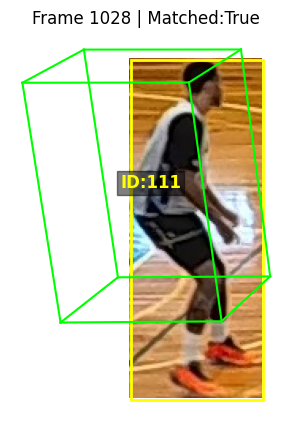

strict_match:True
[DEBUG] frame=1029: 11 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1429.0341515691632, 726.8468727160873, 105.02802000473957, 163.70101339010046]
  [DEBUG] det=[1178.6424560546875, 1077.875, 156.21191, 380.77246], IoU=0.0000
  [DEBUG] det=[1889.79833984375, 765.1314392089844, 105.08838, 216.12213], IoU=0.0000
  [DEBUG] det=[2344.341064453125, 792.700927734375, 75.2168, 202.60583], IoU=0.0000
  [DEBUG] det=[1608.6595458984375, 949.9194641113281, 83.23096, 346.97455], IoU=0.0000
  [DEBUG] det=[784.9037475585938, 697.6900634765625, 59.26538, 186.91846], IoU=0.0000
  [DEBUG] det=[1521.2607421875, 767.7409057617188, 102.079834, 191.69238], IoU=0.0447
  [DEBUG] det=[2567.6575927734375, 805.32861328125, 68.89673, 153.00183], IoU=0.0000
  [DEBUG] det=[1476.1066284179688, 738.514892578125, 59.596313, 162.5083], IoU=0.4877
  [DEBUG] det=[1599.820556640625, 744.7981567382812, 71.04663, 147.12634], IoU=0.0000
  [DEBUG] det=[1599.0215454101562, 744.3433837890625, 60.685913

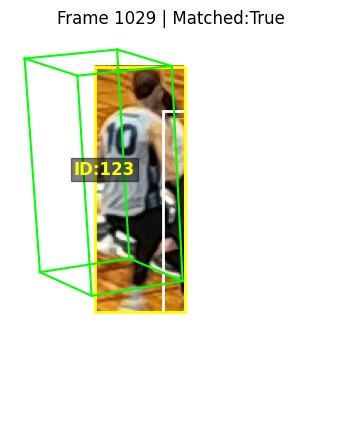

strict_match:True
[DEBUG] frame=1061: 11 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1545.3316032002544, 800.0598783315728, 178.63495161832043, 217.17007253169015]
  [DEBUG] det=[1178.1947631835938, 1073.8839721679688, 151.99231, 386.72375], IoU=0.0000
  [DEBUG] det=[1632.3017578125, 964.9572448730469, 121.22754, 307.45367], IoU=0.0672
  [DEBUG] det=[1922.8818359375, 793.8308410644531, 83.735596, 255.27362], IoU=0.0000
  [DEBUG] det=[2332.85693359375, 819.8384399414062, 75.08789, 188.92639], IoU=0.0000
  [DEBUG] det=[784.613525390625, 700.1634521484375, 60.517822, 187.24072], IoU=0.0000
  [DEBUG] det=[1718.62744140625, 740.725341796875, 98.01953, 205.38464], IoU=0.0134
  [DEBUG] det=[1550.682861328125, 817.6876525878906, 90.96167, 215.26703], IoU=0.4512
  [DEBUG] det=[1797.0563354492188, 748.2310180664062, 77.30676, 172.11292], IoU=0.0000
  [DEBUG] det=[1254.4254150390625, 868.1898193359375, 123.71045, 151.9519], IoU=0.0000
  [DEBUG] det=[1874.7880249023438, 907.6689453125, 164

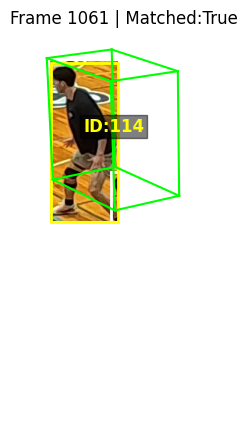

strict_match:True
[DEBUG] frame=1061: 11 boxes, strict>0.35, loose>0.175
[DEBUG] voxel_bbox=[1254.4660136227646, 841.7958804976438, 177.71656133093188, 156.51566783648855]
  [DEBUG] det=[1178.1947631835938, 1073.8839721679688, 151.99231, 386.72375], IoU=0.0000
  [DEBUG] det=[1632.3017578125, 964.9572448730469, 121.22754, 307.45367], IoU=0.0000
  [DEBUG] det=[1922.8818359375, 793.8308410644531, 83.735596, 255.27362], IoU=0.0000
  [DEBUG] det=[2332.85693359375, 819.8384399414062, 75.08789, 188.92639], IoU=0.0000
  [DEBUG] det=[784.613525390625, 700.1634521484375, 60.517822, 187.24072], IoU=0.0000
  [DEBUG] det=[1718.62744140625, 740.725341796875, 98.01953, 205.38464], IoU=0.0000
  [DEBUG] det=[1550.682861328125, 817.6876525878906, 90.96167, 215.26703], IoU=0.0000
  [DEBUG] det=[1797.0563354492188, 748.2310180664062, 77.30676, 172.11292], IoU=0.0000
  [DEBUG] det=[1254.4254150390625, 868.1898193359375, 123.71045, 151.9519], IoU=0.5272
  [DEBUG] det=[1874.7880249023438, 907.6689453125, 164

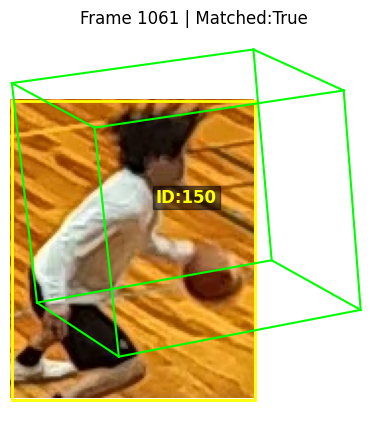

1060にデータがありません
1059にデータがありません
1058にデータがありません
1057にデータがありません
1056にデータがありません
1055にデータがありません
1054にデータがありません
1053にデータがありません
1052にデータがありません
1051にデータがありません
1050にデータがありません
1049にデータがありません
1048にデータがありません
1047にデータがありません
1046にデータがありません
このセル: 14.273 秒, 合計: 16.514 秒


In [16]:
t0 = time.perf_counter()

processed_start_events = start_events.copy()

for idx in start_events.index:
    #print(idx)
    single = start_events.loc[[idx]].copy()
    single.head(1)
    cam = single.loc[idx, 'best_camera']
    cfg = cam_settings[cam]

    modified = trace_and_overlay_for_events(
        events_df=single,
        merged_df=merged_df_iou,
        direction=-1,
        extrinsics_file=extr_file,
        internal_params=internal_params,
        distortion_params=distortion_params,
        measurement_key=measurement_key,
        camera_key=cam,
        aux_folder=cfg['aux_folder'],
        main_folder=cfg['main_folder'],
        vis_map=vis_map,
        aux_ext=".jpg",
        main_ext=".jpg",
        aux_frame_fmt="{:06d}",
        max_steps=max_steps_start,
        skip_frames=skip_param_start
    )
    
    if modified is None or modified.empty:
        continue

    # modified から個別に取り出してセルに書き込む
    for col in ["matched_frame","matched_image_path","matched_x","matched_y","matched_w","matched_h"]:
        processed_start_events.at[idx, col] = modified.at[idx, col]

# 各セルの末尾
t1 = time.perf_counter()
elapsed = t1 - t0

# グローバル変数に足し込む
total_time += elapsed
print(f"このセル: {elapsed:.3f} 秒, 合計: {total_time:.3f} 秒")

In [17]:
t0 = time.perf_counter()

processed_end_events = end_events.copy()

for idx in end_events.index:
    single = end_events.loc[[idx]].copy()
    cam = single.loc[idx, 'best_camera']
    cfg = cam_settings[cam]

    modified = trace_and_overlay_for_events(
        events_df=single,
        merged_df=merged_df_iou,
        direction=1,
        extrinsics_file=extr_file,
        internal_params=internal_params,
        distortion_params=distortion_params,
        measurement_key=measurement_key,
        camera_key=cam,
        aux_folder=cfg['aux_folder'],
        main_folder=cfg['main_folder'],
        vis_map=vis_map,
        aux_ext=".jpg",
        main_ext=".jpg",
        aux_frame_fmt="{:06d}",
        max_steps=max_steps_end,
        skip_frames=skip_param_end
    )
    
    print("modified empty?", modified is None or modified.empty)
    if modified is not None and not modified.empty:
        print("modified.index:", modified.index.tolist())

    if modified is None or modified.empty:
        continue


    # modified から個別に取り出してセルに書き込む
    for col in ["matched_frame","matched_image_path","matched_x","matched_y","matched_w","matched_h"]:
        processed_end_events.at[idx, col] = modified.at[idx, col]

# 各セルの末尾
t1 = time.perf_counter()
elapsed = t1 - t0

# グローバル変数に足し込む
total_time += elapsed

print(f"このセル: {elapsed:.3f} 秒, 合計: {total_time:.3f} 秒")

modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
modified empty? True
このセル: 0.028 秒, 合計: 16.542 秒


In [18]:
# それぞれの射影結果を統合して、dfとして得る構造
t0 = time.perf_counter()

# 1) 再結合
merged_events = pd.concat(
    [processed_start_events, processed_end_events],
    ignore_index=True
)

# 2) 元の順序（インデックス順など）に戻したい場合
merged_events = merged_events.sort_index()

# （あるいはフレーム順にソートしたい場合など）
merged_events = merged_events.sort_values(['session_start'])

# 3) 必要であればインデックスを振り直す
# merged_events = merged_events.reset_index(drop=True)

# 4) CSV に書き出し
merged_events.to_csv(output_dir, index=False)

# 各セルの末尾
t1 = time.perf_counter()
elapsed = t1 - t0

# グローバル変数に足し込む
total_time += elapsed

print(f"このセル: {elapsed:.3f} 秒, 合計: {total_time:.3f} 秒")

このセル: 0.007 秒, 合計: 16.549 秒
